In [1]:
import os
import numpy as np
import mne
mne.set_log_level('error')
import matplotlib
import matplotlib.pyplot as plt
from functions import *
#tplotlib.use('TkAgg')

Could not load PyEMD


### Loading the data

In [2]:
# data_path = "/Users\sunnivlf\Documents/Data Set Alcohol Detector/Subjects"
data_path = "../Data Set Alcohol Detector/Subjects"
#data_path = "../Data Set Alcohol Detector/Subjects"
p_id = "/" + "sub-P019" + "/" + "ses-S002" + "/" + "sub-P019_ses-S002_task-Default_run-005"
raw = mne.io.read_raw_fif(data_path + "/" + p_id + "_eeg.fif", preload=True)

Plotting the elctrode placement on the scalp. The optimal channels for alcoholism detection are: Fp1, AF7, AF8, FC4, FC5, FC6, T7, Cz, PO7, PO8, O1, Oz. We want to look at one channel on the left side (Fp1) and one on the right side (PO8) of the scalp.

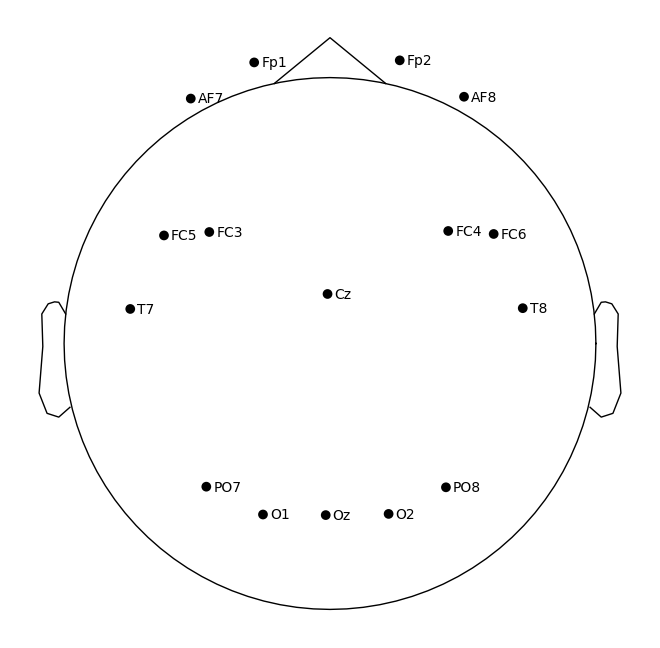

In [3]:
raw.plot_sensors(show_names=True);

### Filtering the data
Highpass filtering is included to remove drifting of the signal, while lowpass filtering will remove power line noise


/Users/kristian/miniconda3/envs/ttk7/lib/python3.8/site-packages/mne/viz/utils.py:161: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


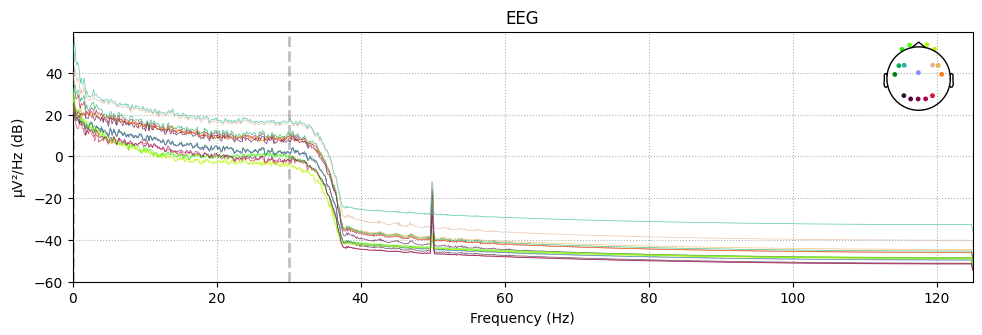

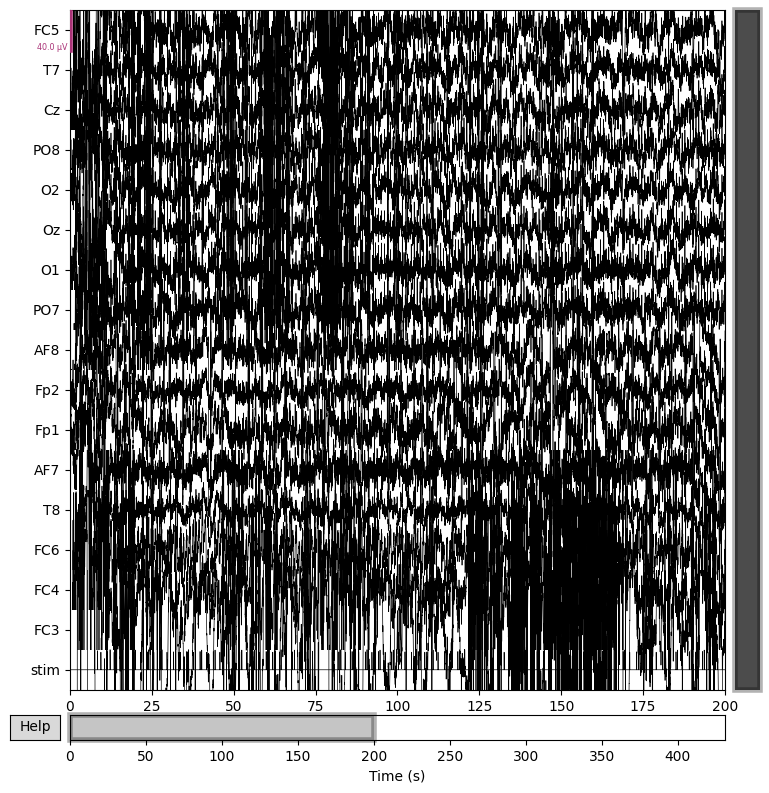

In [4]:
low_cut = 0.1 
hi_cut  = 30
raw_filt = raw.copy().filter(low_cut, hi_cut)
raw_filt.compute_psd(fmax=125).plot(picks="data", exclude="bads");
raw_filt.plot(highpass=0.1, lowpass=30, duration=200);

Choose one channel to use for this experiment. Fp2 is one of the frontal electrodes. The data and time is extracted from the filtered raw data, as numpy arrays.

In [5]:
channels = ['PO8', 'Fp1']

picks = mne.pick_channels(ch_names = raw_filt.info['ch_names'], include=channels)
data, time = raw_filt[picks, :]  

channel_nr = 1

The signal is visualized using matplotlib.

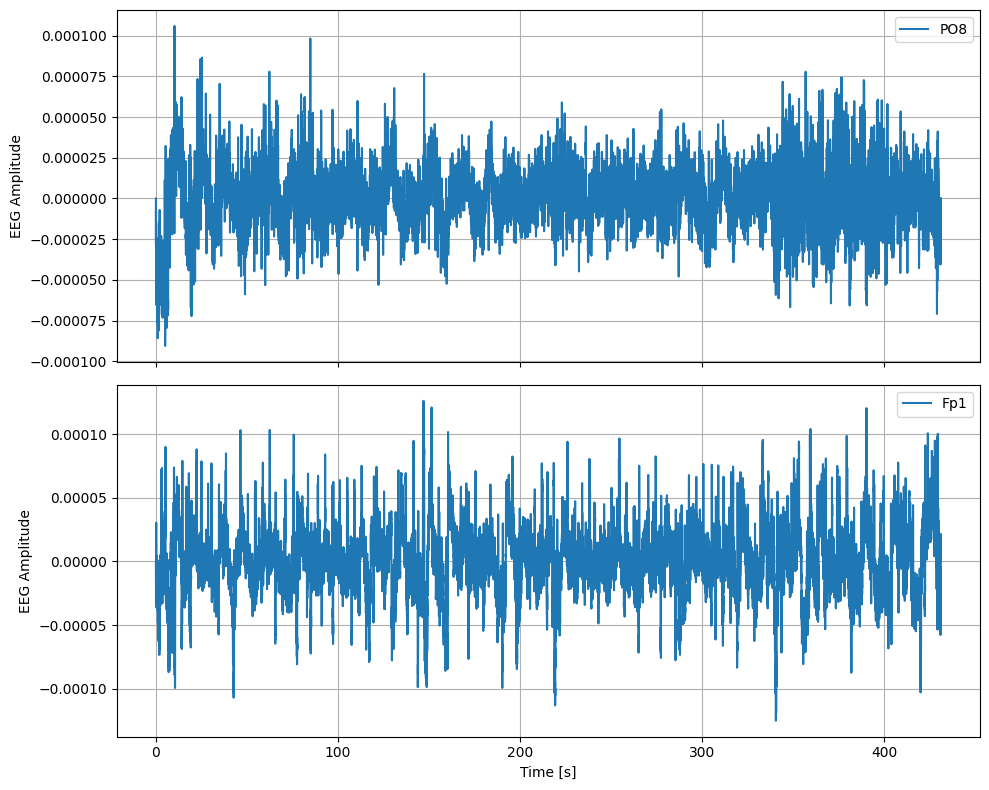

In [6]:
plt.figure(figsize=(10, 4*len(channels)))
for idx, channel in enumerate(channels):
    ax = plt.subplot(2, 1, idx+1)
    plt.plot(time, data[idx], label=channel)
    plt.ylabel('EEG Amplitude')
    plt.grid(True)
    if idx < len(channels) - 1:
        ax.set_xticklabels([])
    else:
        plt.xlabel('Time [s]')
    plt.legend()
    # plt.ylim([-0.000110, 0.000110])
    
plt.tight_layout()
plt.show()

In [7]:
sample_rate = raw.info['sfreq']
window_size = 2

s1 = 100
s2 = s1 + window_size

delta1 = int(sample_rate*s1)
delta2 = int(sample_rate*s2)

d0 = data[0][delta1:delta2]
d1 = data[1][delta1:delta2]
t = time[delta1:delta2]
num_samples = len(d0)

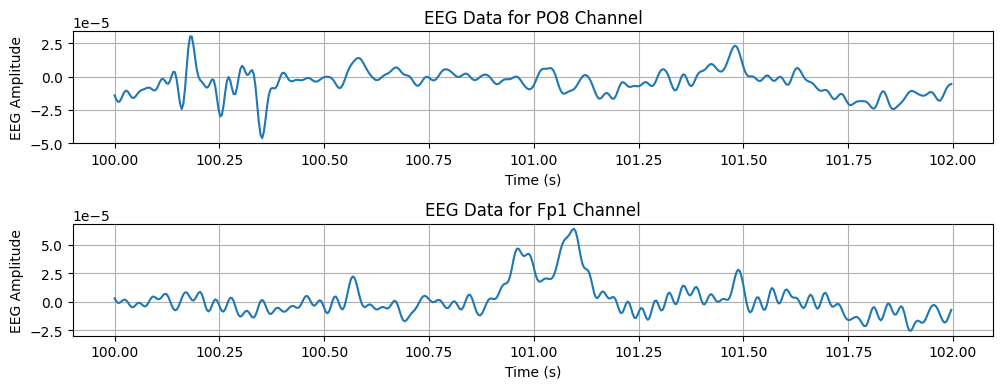

In [8]:
plt.figure(figsize=(10, 4))
plt.subplot(211)
plt.plot(t, d0)
plt.xlabel('Time (s)')
plt.ylabel('EEG Amplitude')
plt.title(f'EEG Data for {channels[0]} Channel')
plt.grid(True)

plt.subplot(212)
plt.plot(t, d1)
plt.xlabel('Time (s)')
plt.ylabel('EEG Amplitude')
plt.title(f'EEG Data for {channels[1]} Channel')
plt.grid(True)

plt.tight_layout()
plt.show()

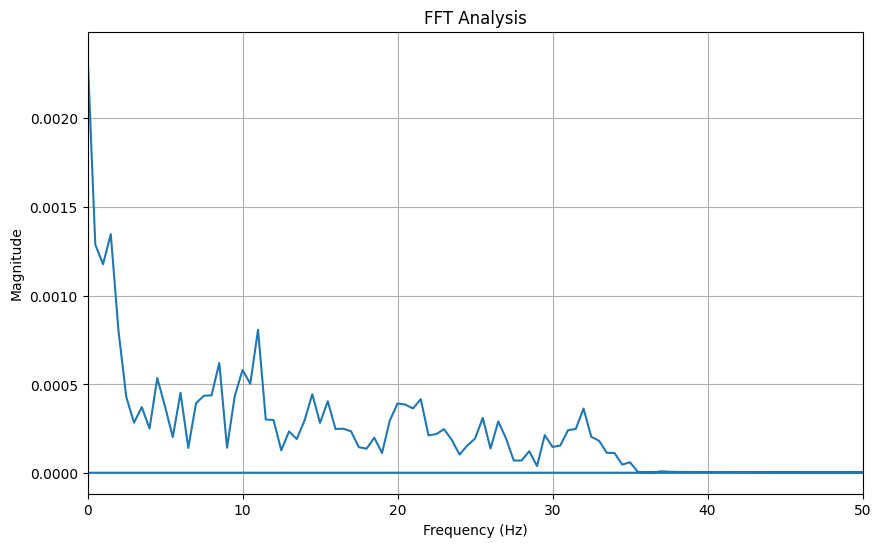

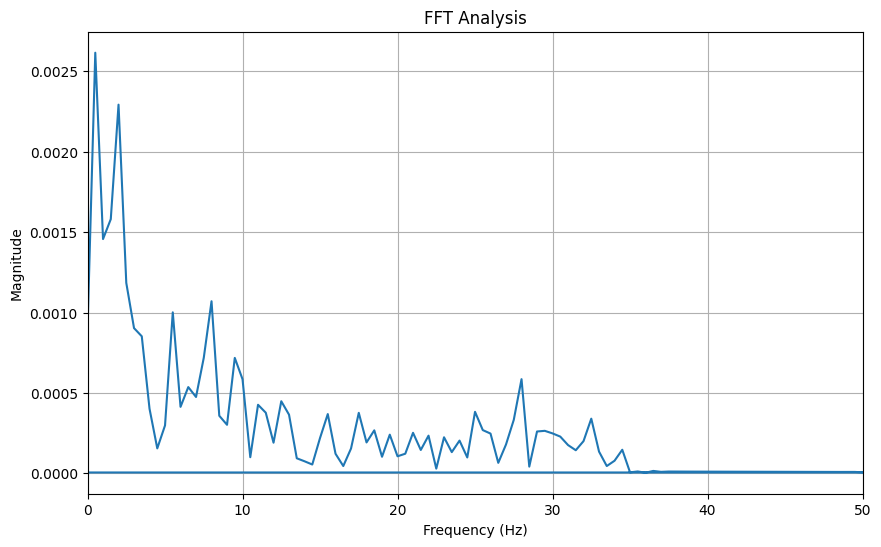

In [9]:
(freq, fft_freq) = fft(d0, num_samples, sample_rate)
(freq, fft_freq) = fft(d1, num_samples, sample_rate)

In [10]:
f, dt, ssx = plot_stft(d0, sample_rate, 50, 5)
f, dt, ssx = plot_stft(d1, sample_rate, 50, 5)

In [11]:
imfs0 = hht(t, d0, plot=False)
imfs1 = hht(t, d1, plot=False)

In [12]:
#cwtm = wt(t, d, sample_rate, w=3.0)

### Plot Fourier Transform of IMFS

In [13]:
def plot_fourier_transform_imf(imfs, num_samples, sample_rate):
    filt_imfs = imfs[0:len(imfs)-1]

    # Set the figure size dynamically based on the number of IMFs
    plt.figure(figsize=(10, 2*len(filt_imfs)))

    for idx, imf in enumerate(filt_imfs):
        freq, fft_res = fft(imf, num_samples, sample_rate, plot=False)
        
        ax = plt.subplot(len(filt_imfs), 1, idx+1)
        plt.plot(freq, fft_res)
        plt.xlim(0, 45)
        
        # If it's not the last subplot, remove the x-axis labels to prevent overlap
        if idx < len(filt_imfs) - 1:
            ax.set_xticklabels([])
        else:
            plt.xlabel('Frequency (Hz)')  # Only add x-axis label to the bottom subplot

        plt.ylabel('Amplitude')

    # Adjust the layout to prevent overlapping
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.subplots_adjust(bottom=0.06)
    plt.show()

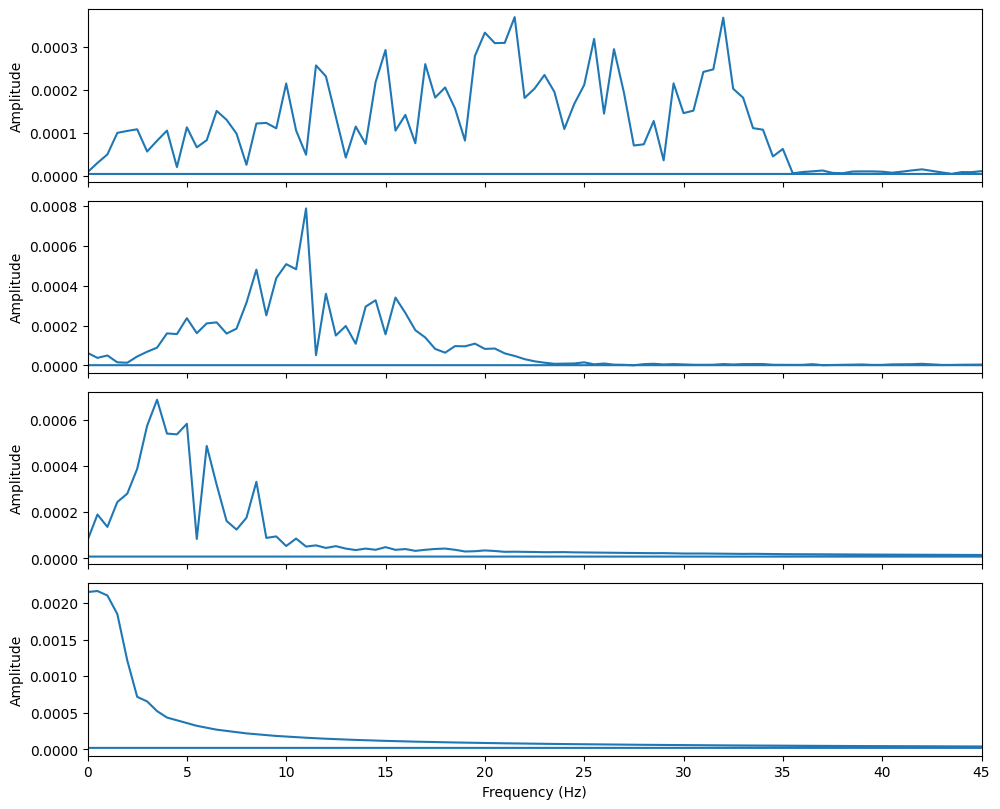

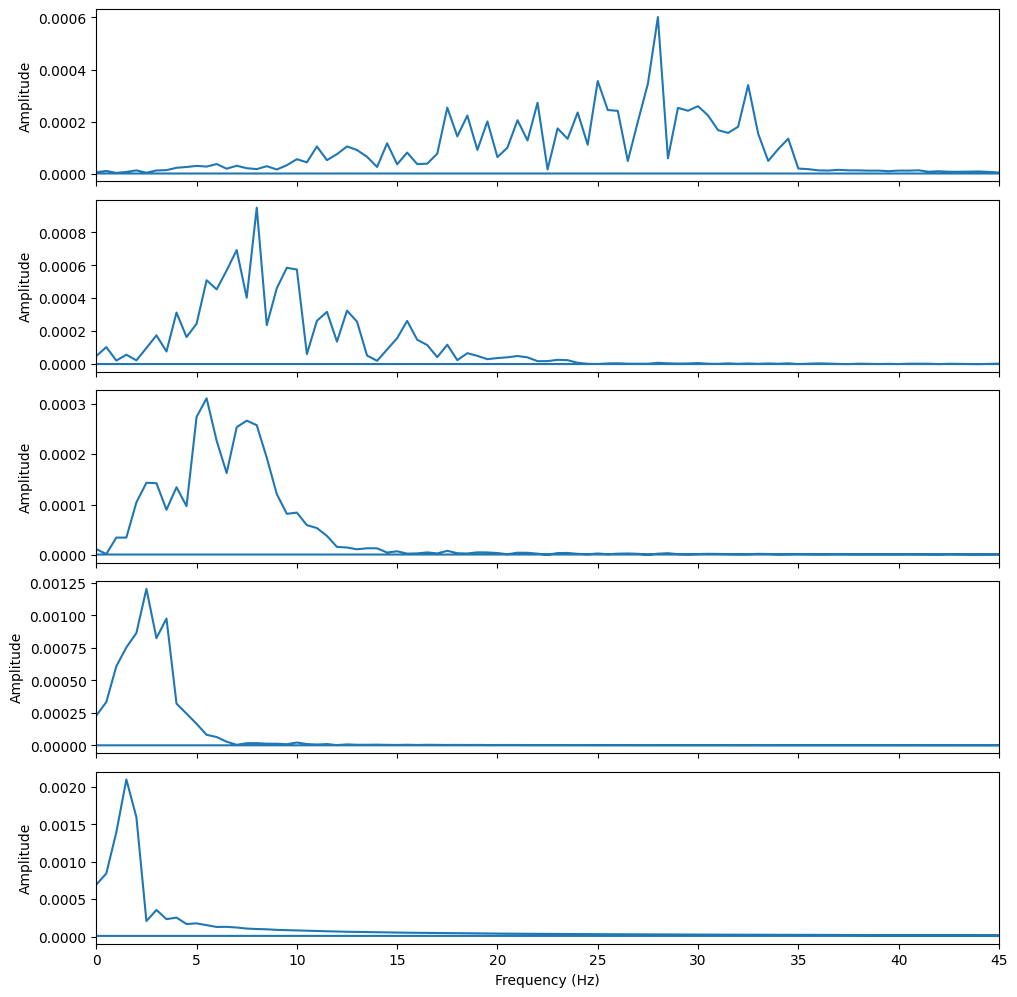

In [14]:
plot_fourier_transform_imf(imfs0, num_samples, sample_rate)
plot_fourier_transform_imf(imfs1, num_samples, sample_rate)

### Short Time Fourier Transform of IMFS

In [15]:
def plot_stft_imf(imfs, nperseg=200, noverlap=0, ylim_min=0, ylim_max=50):
    filt_imfs = imfs[0:len(imfs)-1]

    # Determine global min and max values for color scale normalization
    vmin = np.inf  # start with infinity
    vmax = -np.inf  # start with negative infinity

    for imf in filt_imfs:
        f, _, Sxx = plot_stft(imf, sample_rate=sample_rate, nperseg=nperseg, noverlap=noverlap, plot=False)
        vmin = min(vmin, np.abs(Sxx).min())  # update vmin
        vmax = max(vmax, np.abs(Sxx).max())  # update vmax

    plt.figure(figsize=(12, 4*len(filt_imfs)))

    # Create subplots and apply the same vmin and vmax to each
    for idx, imf in enumerate(filt_imfs):
        f, dt, Sxx = plot_stft(imf, sample_rate=sample_rate, nperseg=nperseg, noverlap=noverlap, plot=False)
        plt.subplot(len(filt_imfs), 1, idx+1)
        plt.pcolormesh(dt, f, np.abs(Sxx), shading='gouraud', vmin=vmin, vmax=vmax)  # Apply the same vmin and vmax
        plt.ylabel('f [Hz]')
        plt.ylim([ylim_min, ylim_max])

    # After creating all subplots, add a single colorbar to the figure
    plt.subplots_adjust(right=0.845)  # Adjust subplot to not overlap with colorbar
    cbar_ax = plt.gcf().add_axes([0.87, 0.15, 0.02, 0.7])  # Position for the colorbar
    plt.colorbar(cax=cbar_ax, label='Magnitude [dB]')

    # Add common xlabel
    plt.xlabel('Time [sec]')
    plt.show()

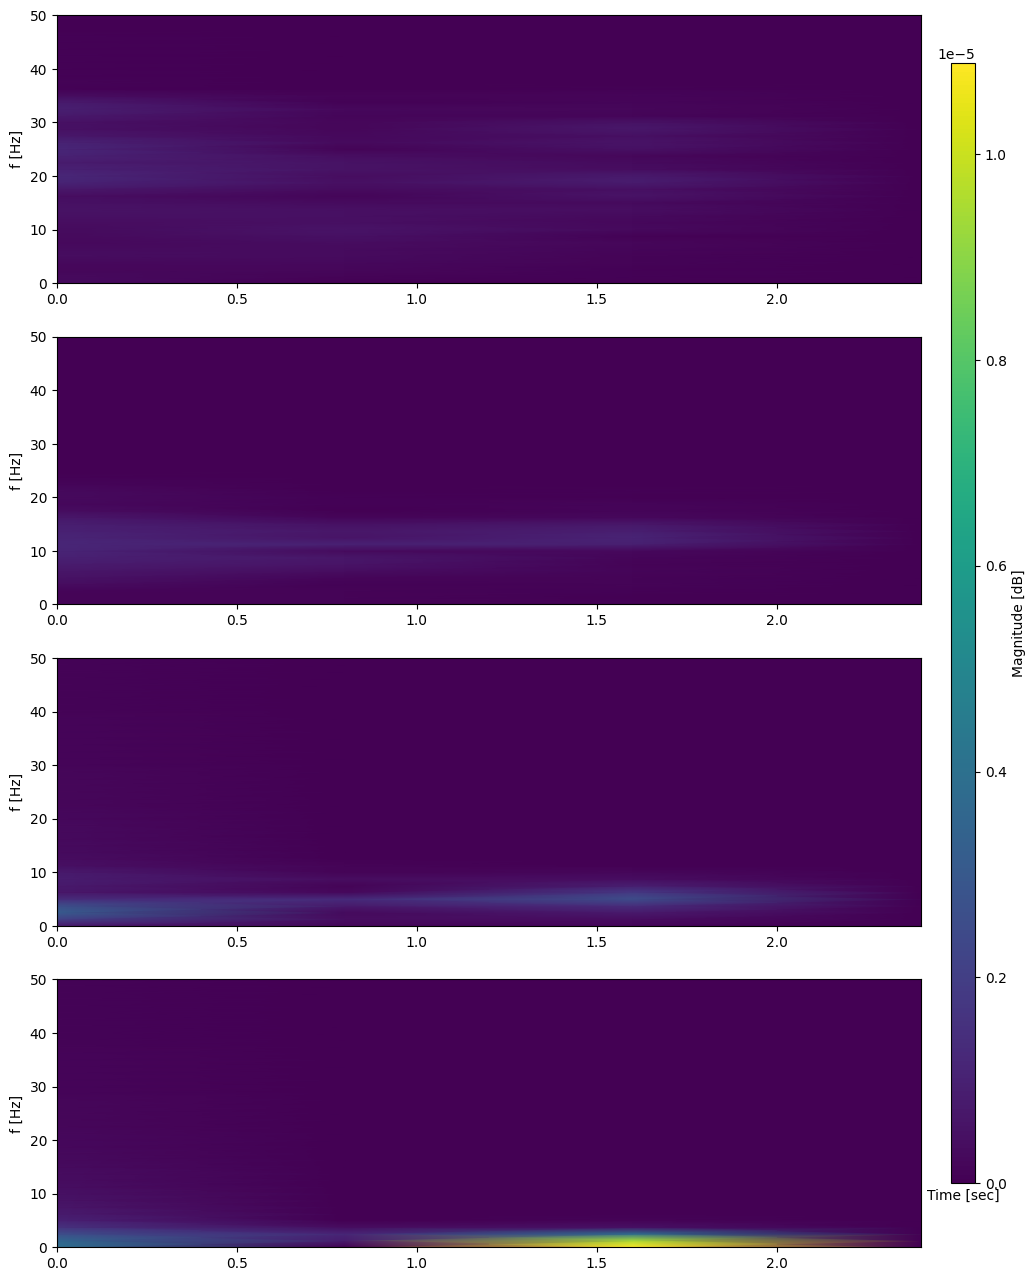

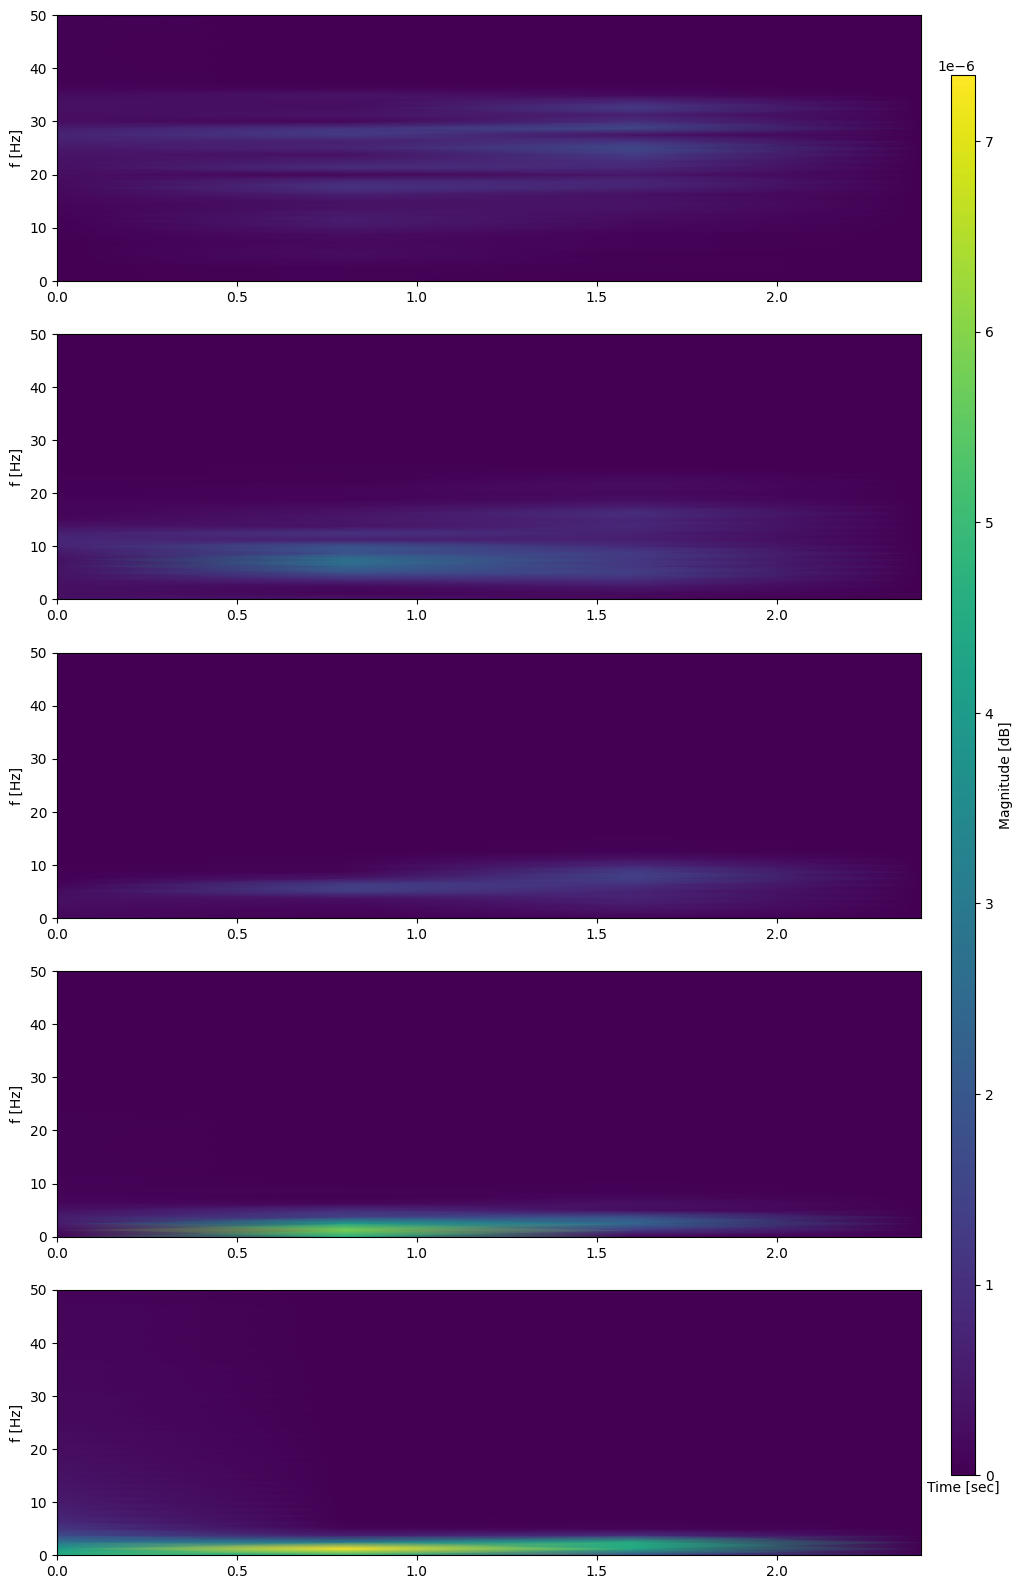

In [16]:
plot_stft_imf(imfs0)
plot_stft_imf(imfs1)

### Plot Wavelet transform

In [17]:
def plot_wavelet_transform_imf(imfs, t, sample_rate, ylim_min=0, ylim_max=50):
    filt_imfs = imfs[0:len(imfs)-1]

    plt.figure(figsize=(16, 4*len(filt_imfs)))
    # Create subplots and apply the same vmin and vmax to each
    for idx, imf in enumerate(filt_imfs):
        cwtm = wt(t, imf, sample_rate, w=6.0)
        ax = plt.subplot(len(filt_imfs), 1, idx+1)
        freq = np.linspace(1, sample_rate/2, 100)
        plt.pcolormesh(t, freq, np.abs(cwtm), cmap='viridis', shading='gouraud')
        if idx < len(filt_imfs) - 1:
            ax.set_xticklabels([])
        else:
            plt.xlabel('Time [s]')  # Only add x-axis label to the bottom subplot
        plt.ylabel('Amplitude')
        plt.ylim([ylim_min, ylim_max])
    plt.show()

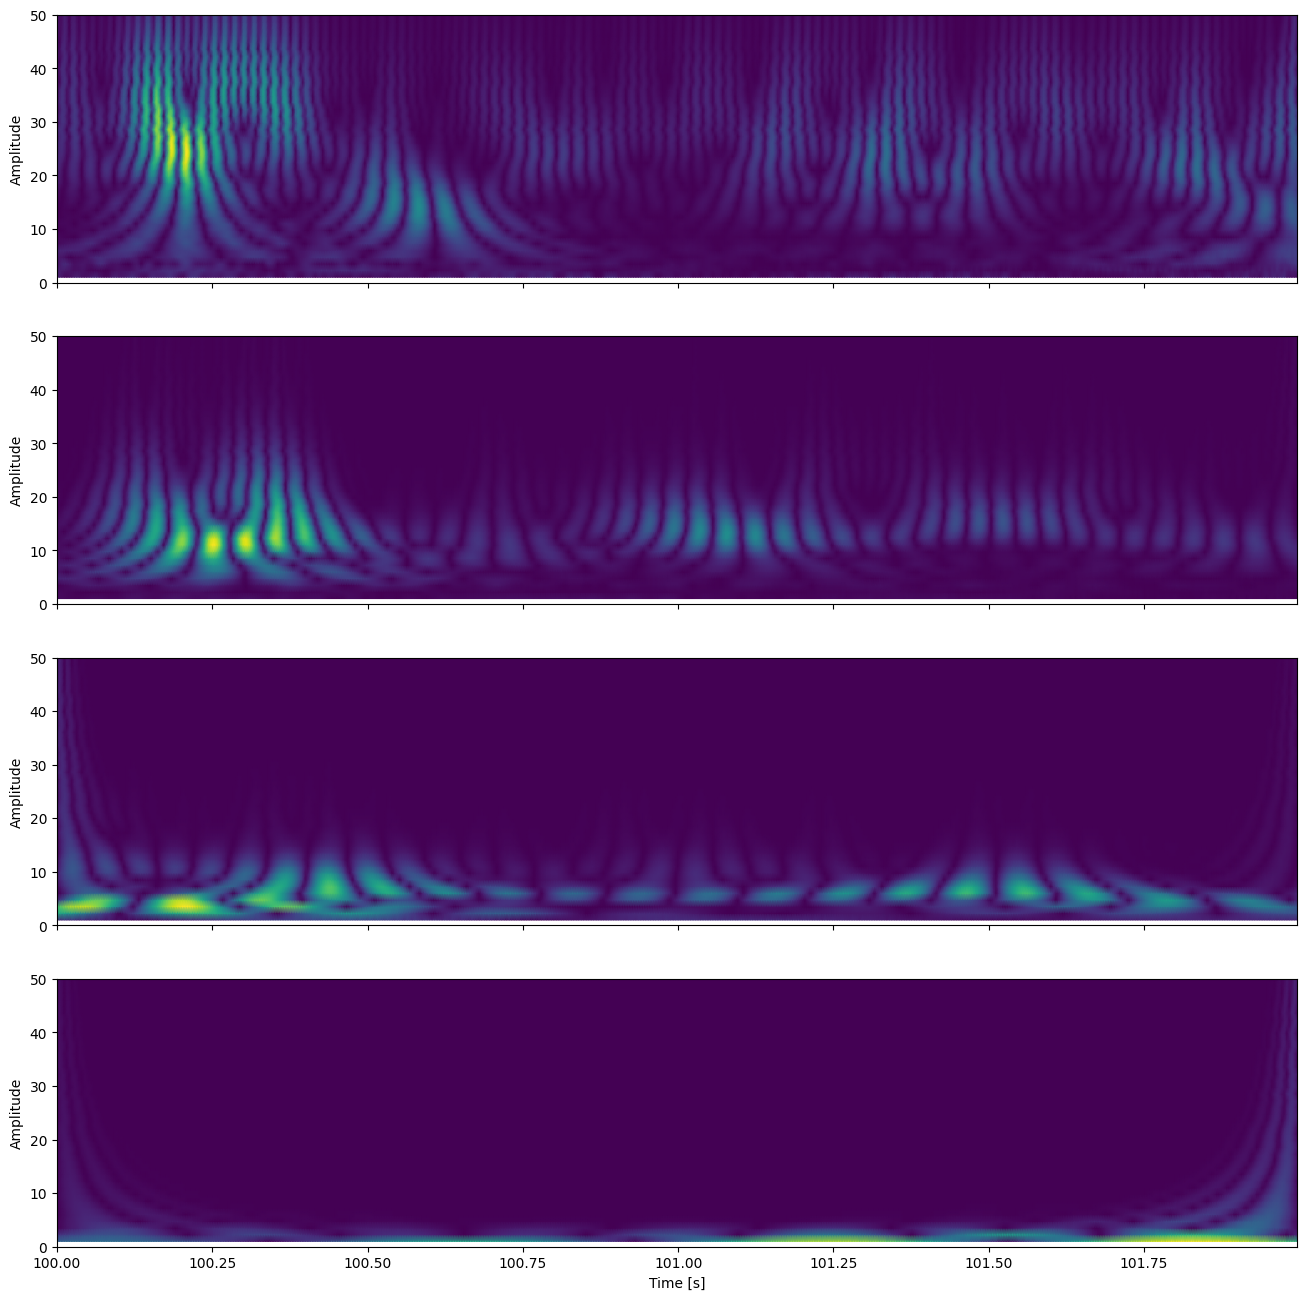

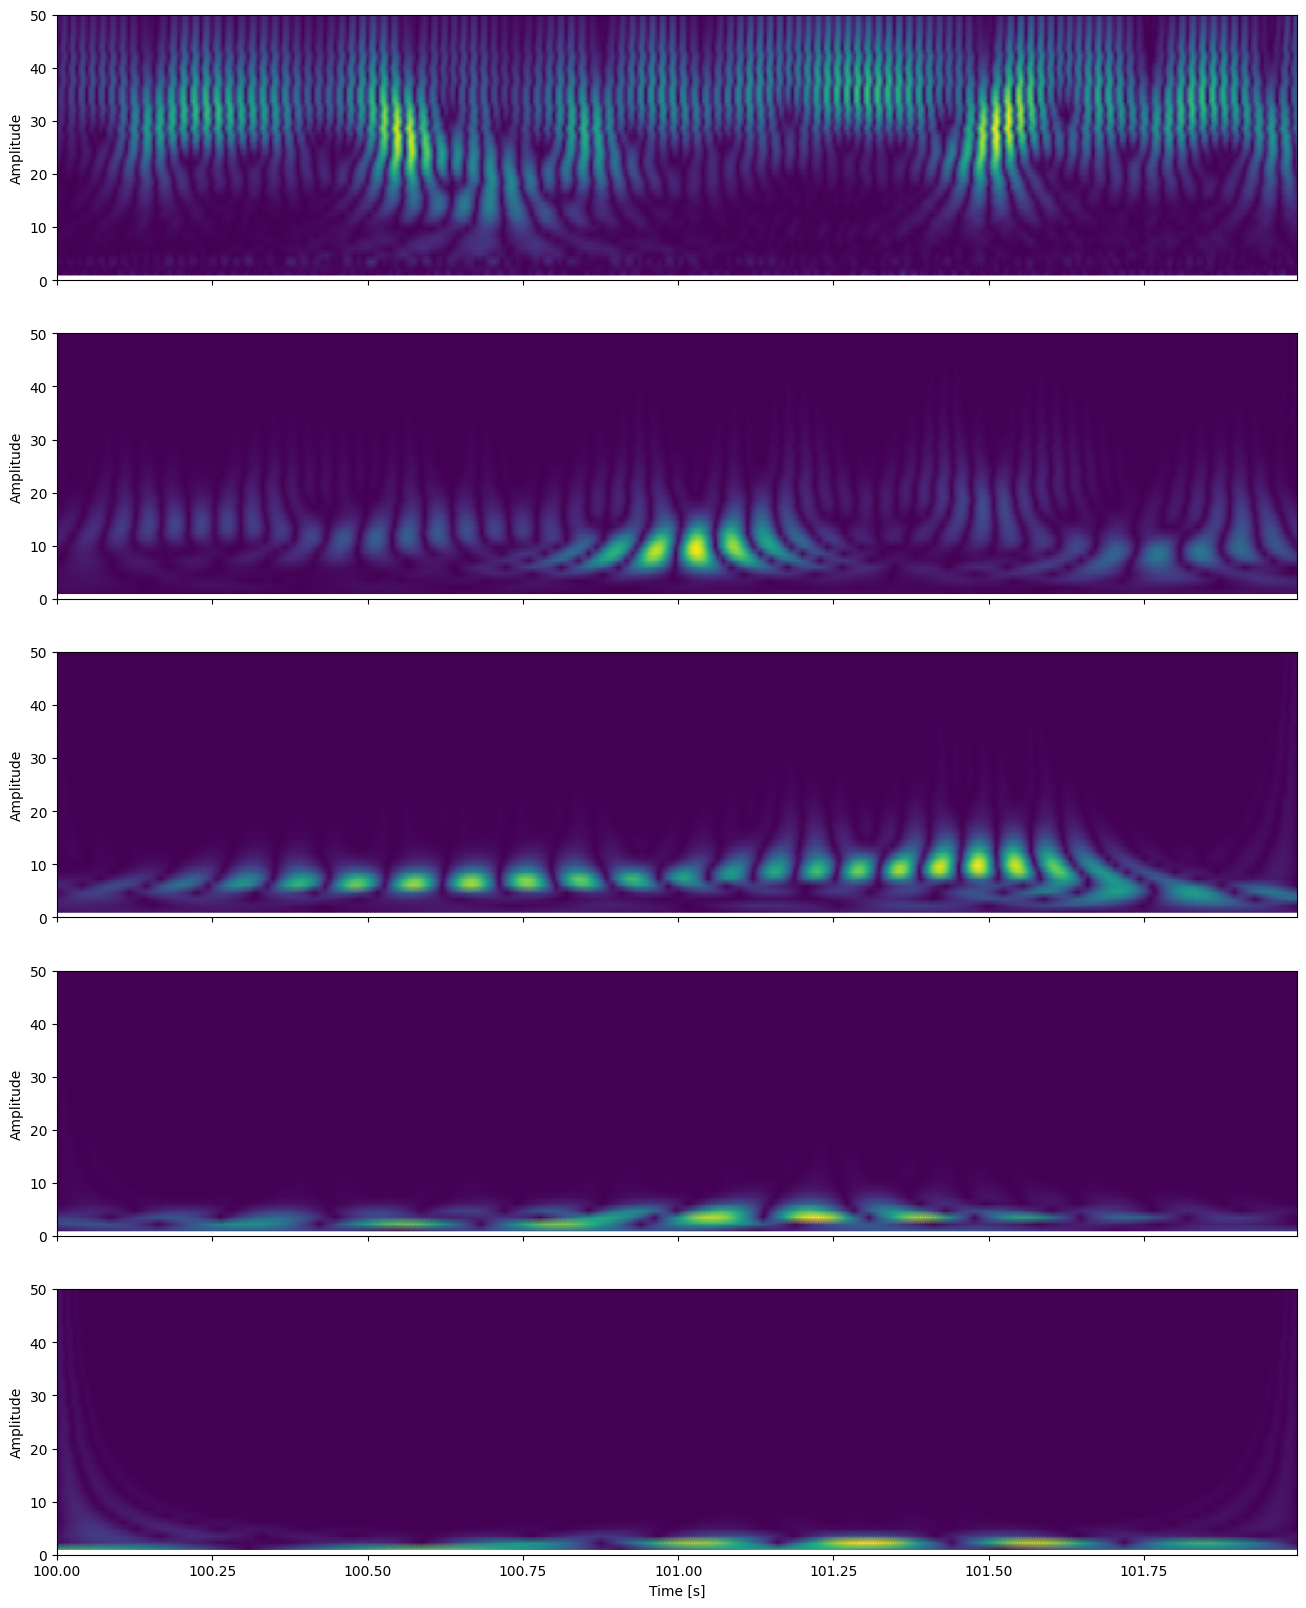

In [18]:
plot_wavelet_transform_imf(imfs0, t, sample_rate)
plot_wavelet_transform_imf(imfs1, t, sample_rate)

### Plot Hilbert Transform

In [19]:
def plot_hilbert_transform_imf(imfs, t, sample_rate, plot_envelope=True, plot_frequency=True):
    filt_imfs = imfs[0:len(imfs)-1]

    envelopes = []
    frequencies = []
    for idx, imf in enumerate(filt_imfs):
        amplitude_envelope, instantaneous_frequency = ht(t, imf, sample_rate, plot=False)
        envelopes.append(amplitude_envelope)
        frequencies.append(instantaneous_frequency)

    if plot_envelope:
        plt.figure(figsize=(16, 3*len(filt_imfs)))
        for idx, envelope in enumerate(envelopes):
            ax = plt.subplot(len(filt_imfs), 1, idx+1)
            plt.plot(t, filt_imfs[idx], label=f'IMF {idx}')
            plt.plot(t, envelope)    
            if idx < len(filt_imfs) - 1:
                ax.set_xticklabels([])
            else:
                plt.xlabel('Time [s]')
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        plt.subplots_adjust(bottom=0.06)
        plt.show()

    if plot_frequency:
        plt.figure(figsize=(16, 3*len(filt_imfs)))
        for idx, frequency in enumerate(frequencies):
            ax = plt.subplot(len(filt_imfs), 1, idx+1)
            plt.plot(t[1:], frequency, label=f'IMF {idx}')    
            if idx < len(filt_imfs) - 1:
                ax.set_xticklabels([])
            else:
                plt.xlabel('Time [s]')
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        plt.subplots_adjust(bottom=0.06)
        plt.show()

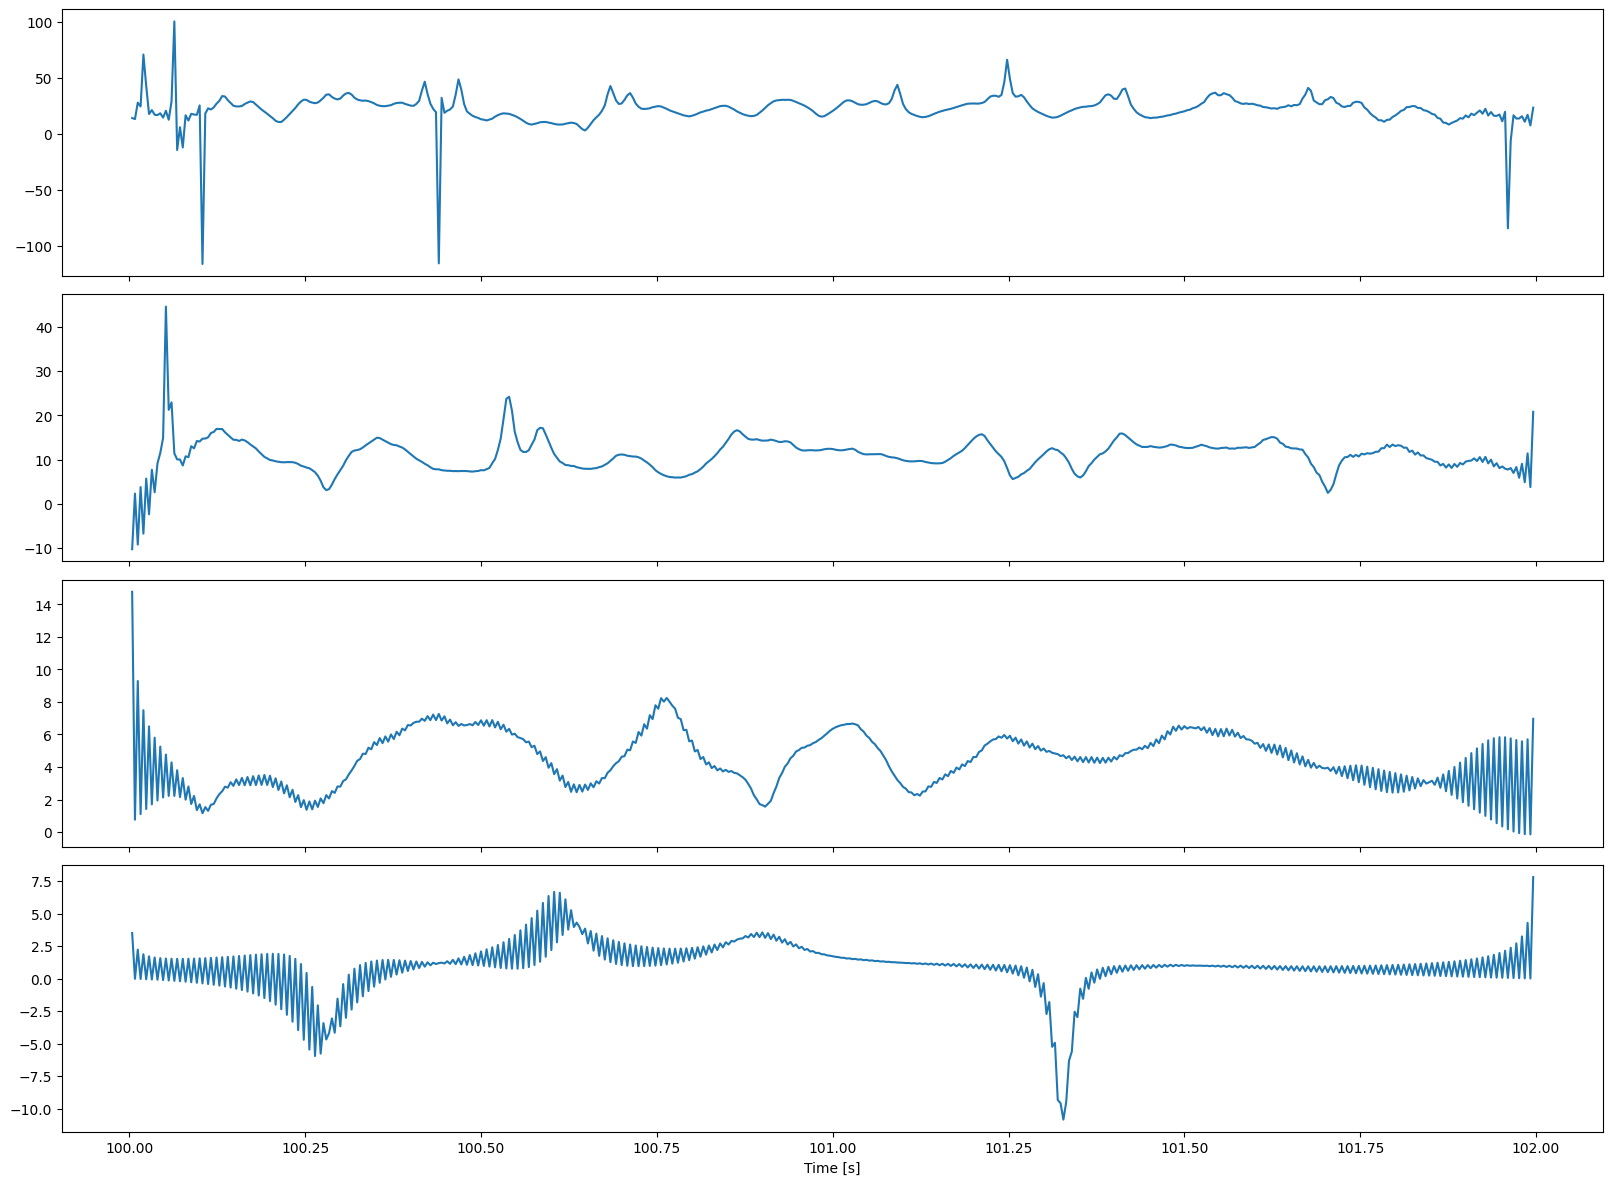

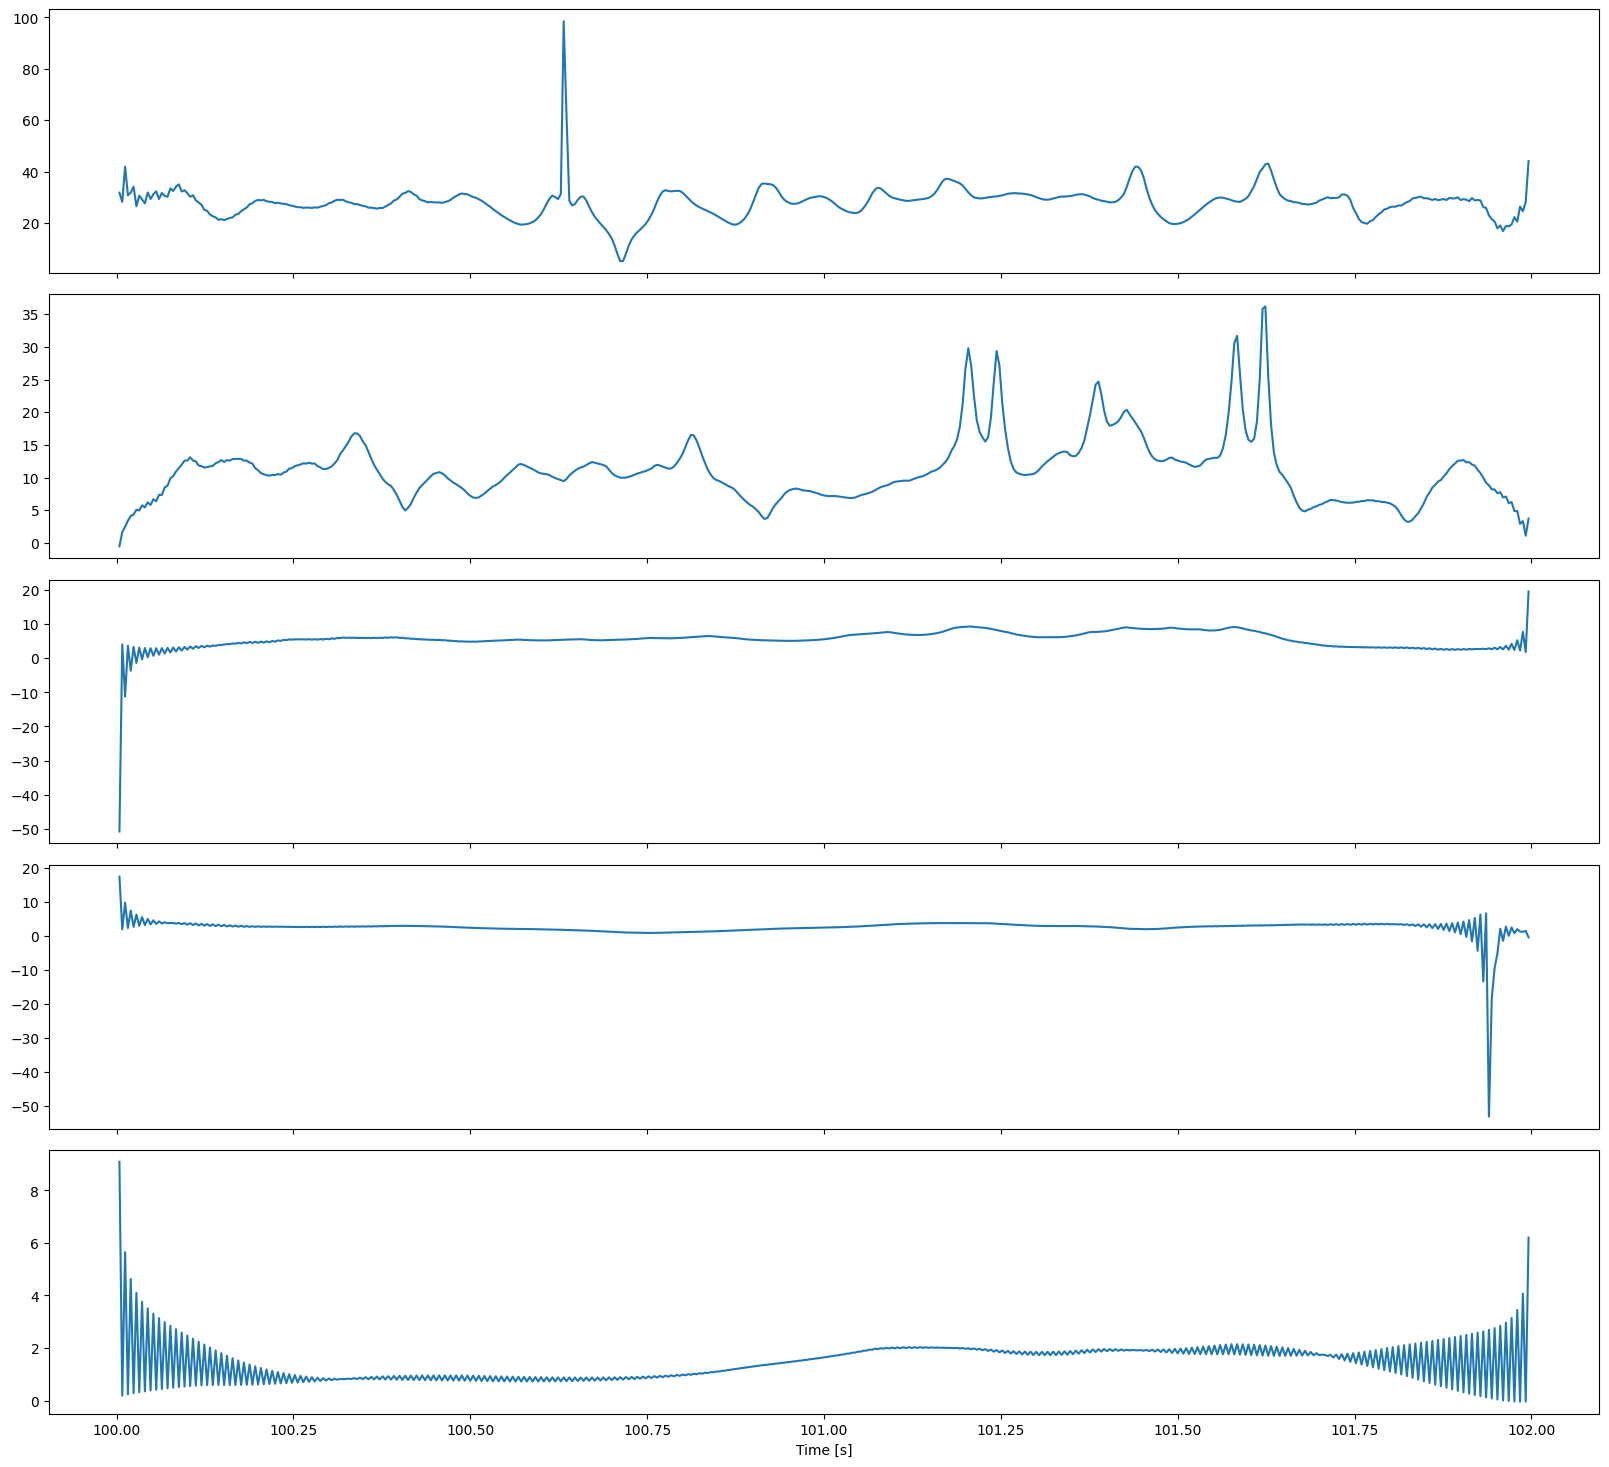

In [20]:
plot_hilbert_transform_imf(imfs0, t, sample_rate, plot_envelope=False)
plot_hilbert_transform_imf(imfs1, t, sample_rate, plot_envelope=False)

### Trying som EEMD and CEEMDAN

In [21]:
if os.path.exists("imfs/eimfs0.npy"):
    with open('imfs/eimfs0.npy', 'rb') as f:
        eimfs0 = np.load(f)
else:
    eimfs0 = extended_emd(t, d0, trials=2000, noise_width=0.01, plot=True)
    with open('imfs/eimfs0.npy', 'wb') as f:
        np.save(f, eimfs0)
if os.path.exists("imfs/eimfs1.npy"):
    with open('imfs/eimfs1.npy', 'rb') as f:
        eimfs1 = np.load(f)
else:
    eimfs1 = extended_emd(t, d1, trials=2000, noise_width=0.01, plot=True)
    with open('imfs/eimfs1.npy', 'wb') as f:
        np.save(f, eimfs1)

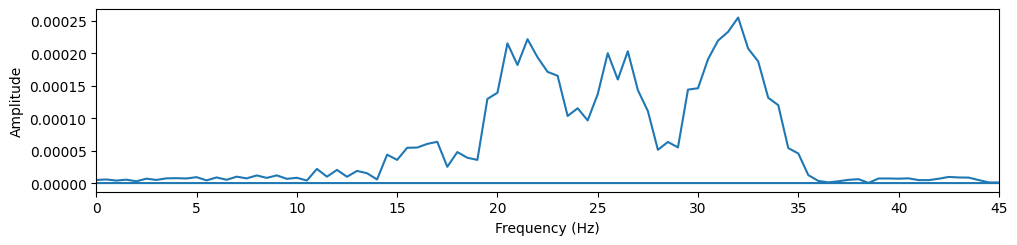

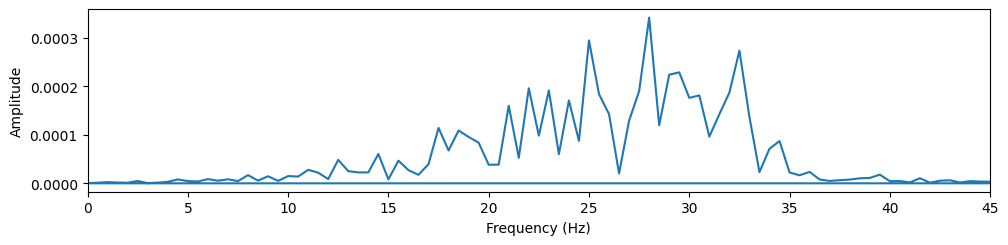

In [22]:
plot_fourier_transform_imf(eimfs0, num_samples, sample_rate)
plot_fourier_transform_imf(eimfs1, num_samples, sample_rate)

In [27]:
if os.path.exists("imfs/cimfs0.npy"):
    with open('imfs/cimfs0.npy', 'rb') as f:
        cimfs0 = np.load(f)
else:
    cimfs0 = ceemdan(t, d0, trials=2000, noise_width=0.01, plot=True)
    with open('imfs/cimfs0.npy', 'wb') as f:
        np.save(f, cimfs0)
if os.path.exists("imfs/cimfs1.npy"):
    with open('imfs/cimfs1.npy', 'rb') as f:
        cimfs1 = np.load(f)
else:
    cimfs1 = ceemdan(t, d1, trials=2000, noise_width=0.01, plot=True)
    with open('imfs/cimfs1.npy', 'wb') as f:
        np.save(f, cimfs1)

# cimfs0 = ceemdan(t, d0, trials=2000, noise_width=0.01, plot=True)
# cimfs1 = ceemdan(t, d1, trials=2000, noise_width=0.01, plot=True)

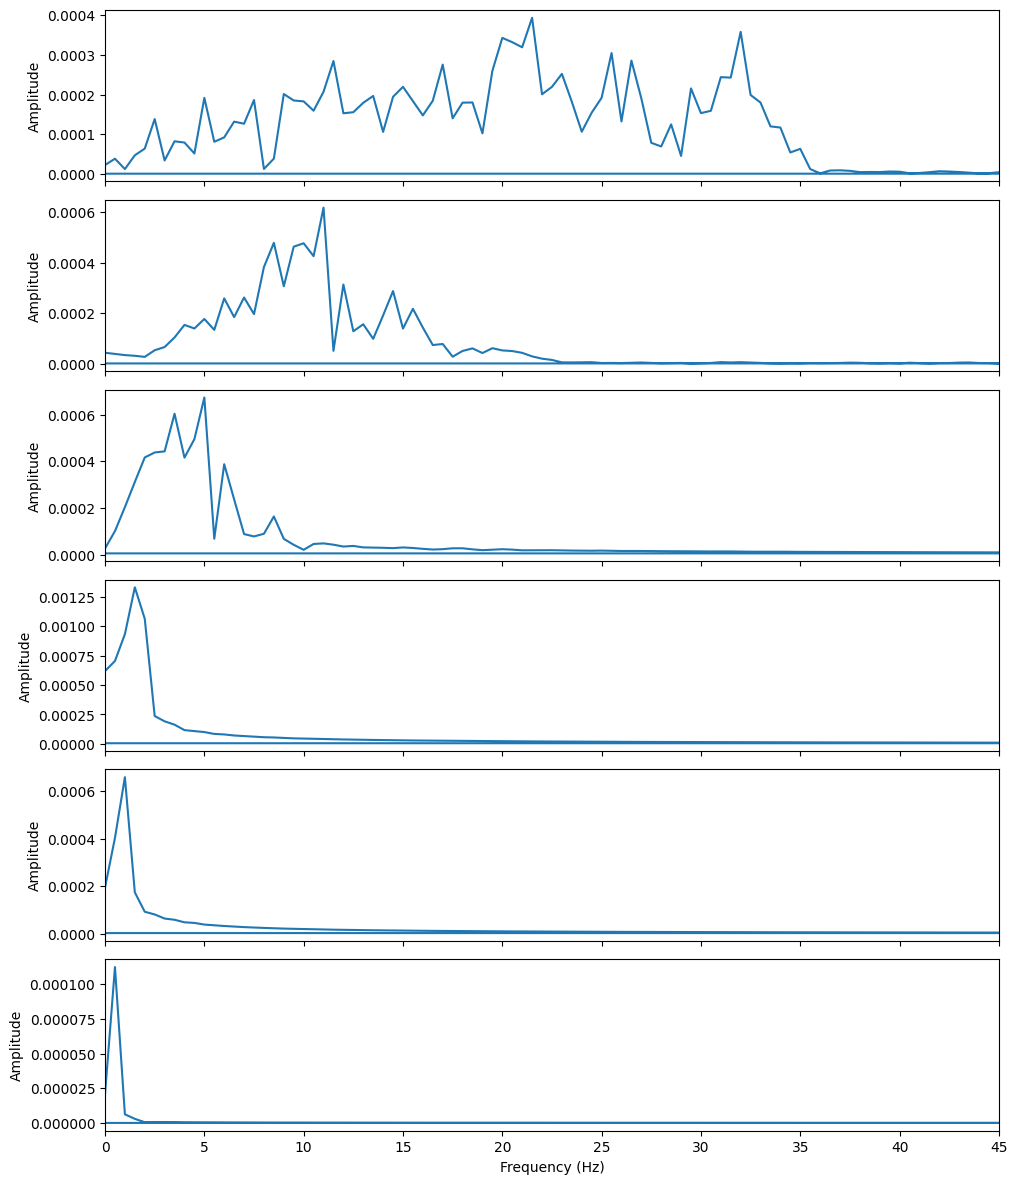

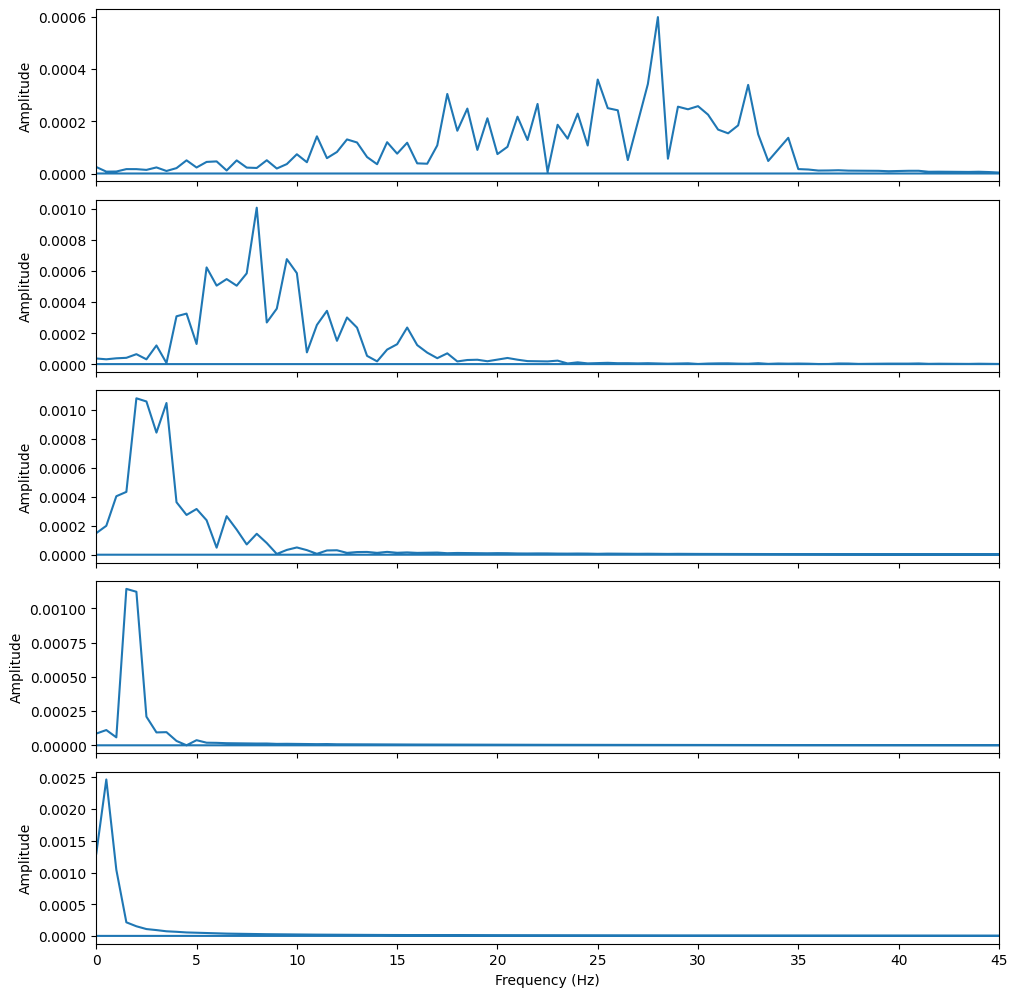

In [28]:
plot_fourier_transform_imf(cimfs0, num_samples, sample_rate)
plot_fourier_transform_imf(cimfs1, num_samples, sample_rate)

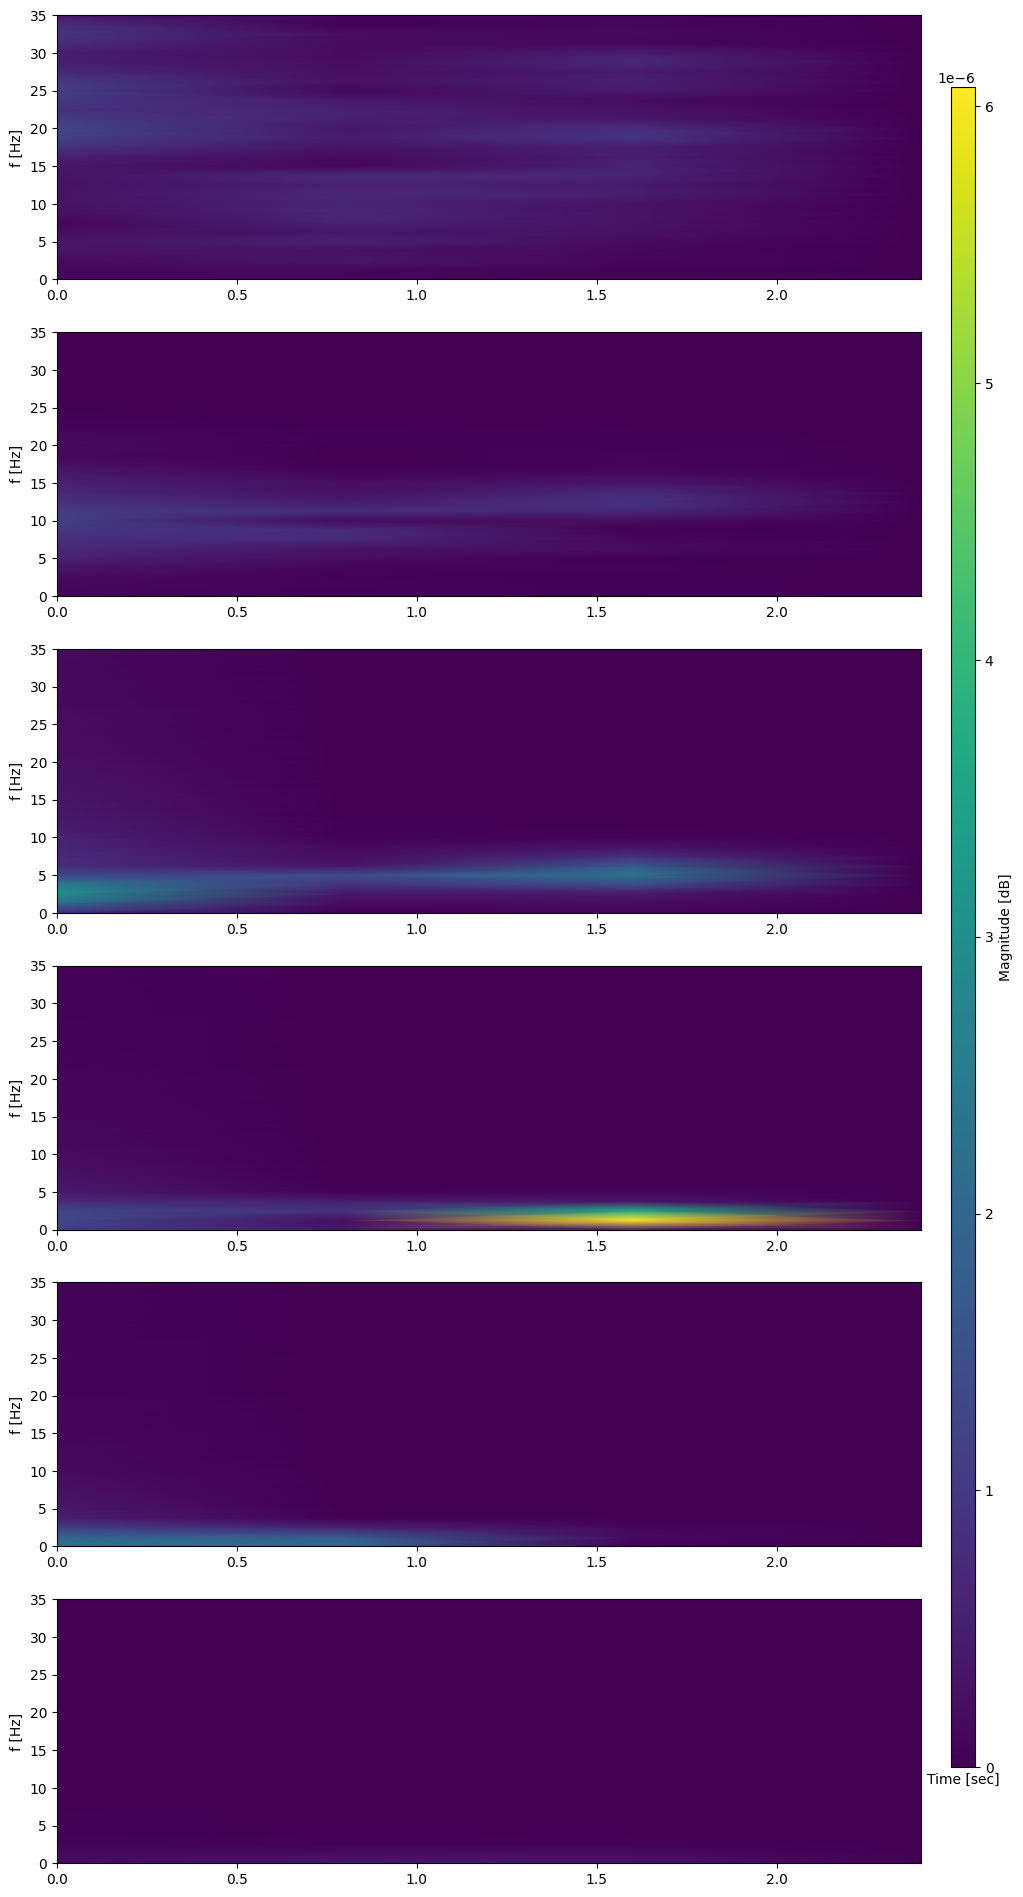

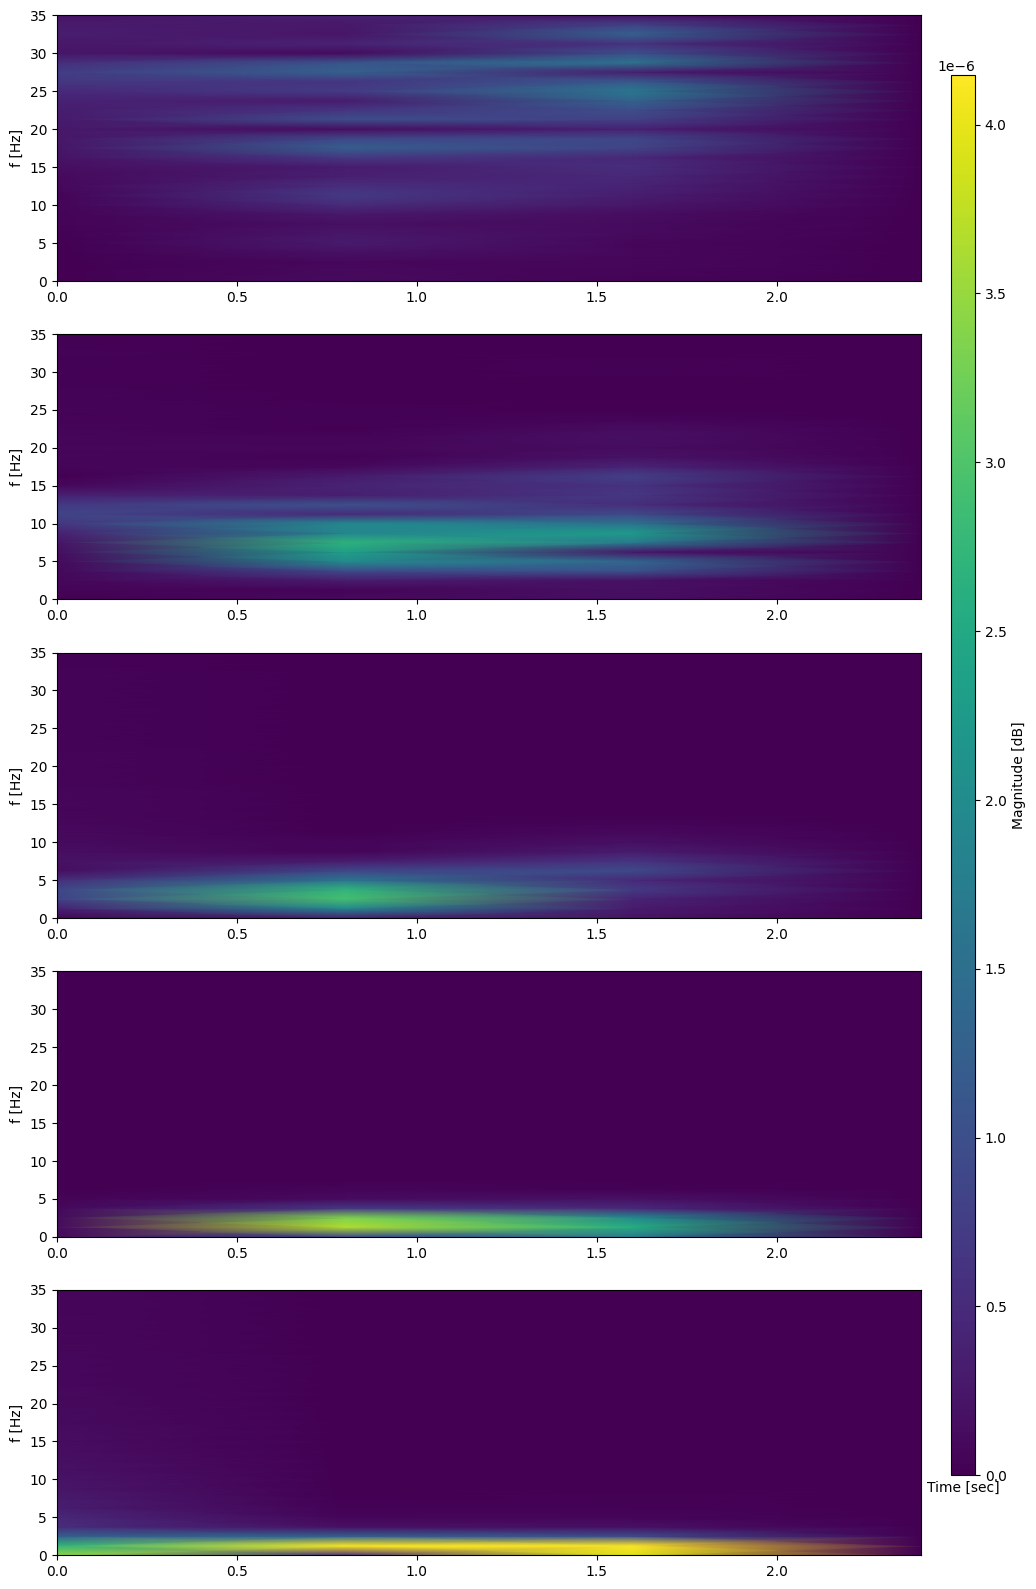

In [29]:
nperseg = 200
noverlap = 0

plot_stft_imf(cimfs0, nperseg=nperseg, noverlap=noverlap, ylim_max=35)
plot_stft_imf(cimfs1, nperseg=nperseg, noverlap=noverlap, ylim_max=35)


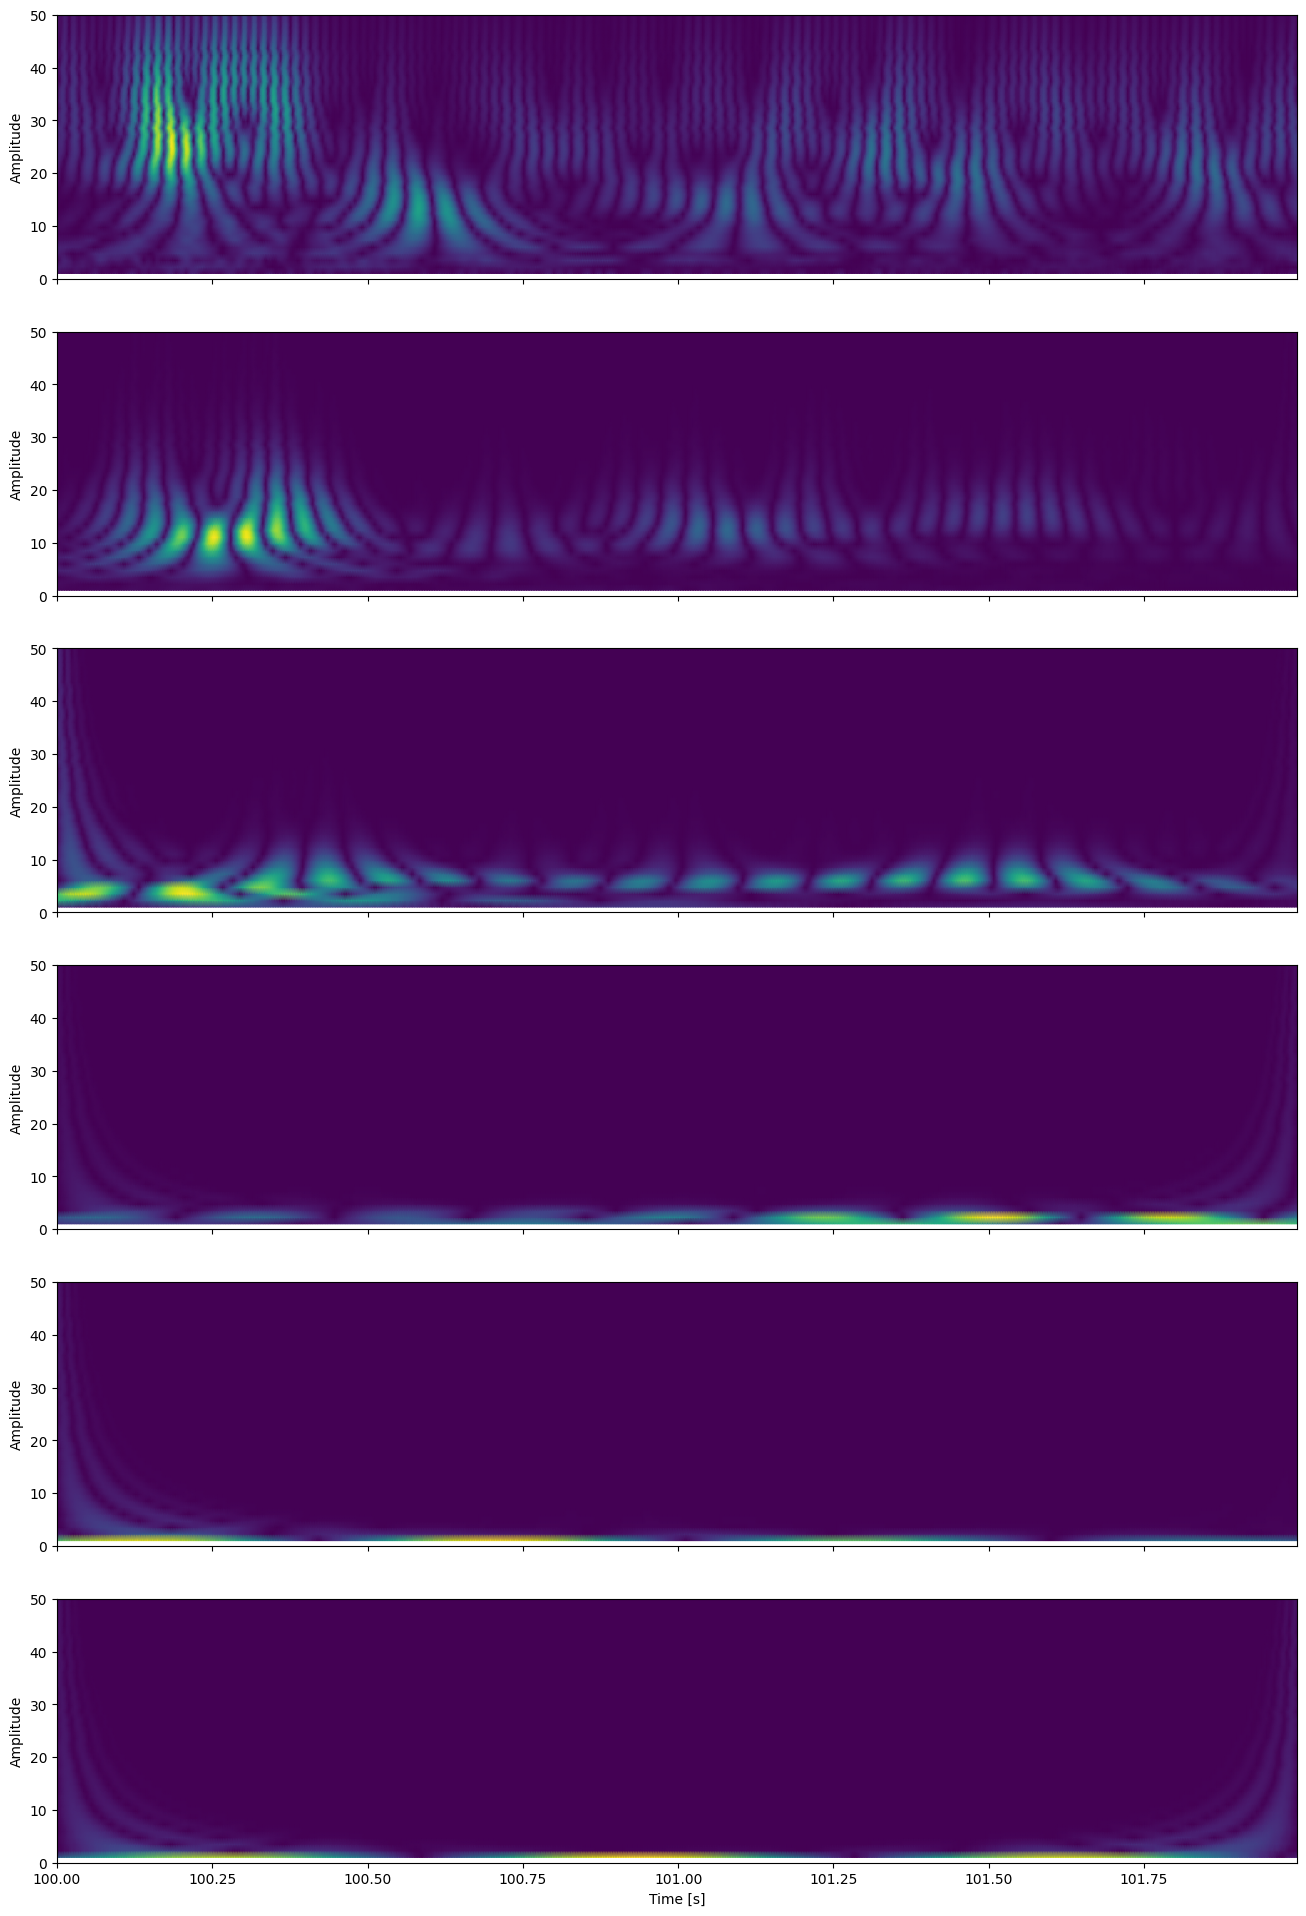

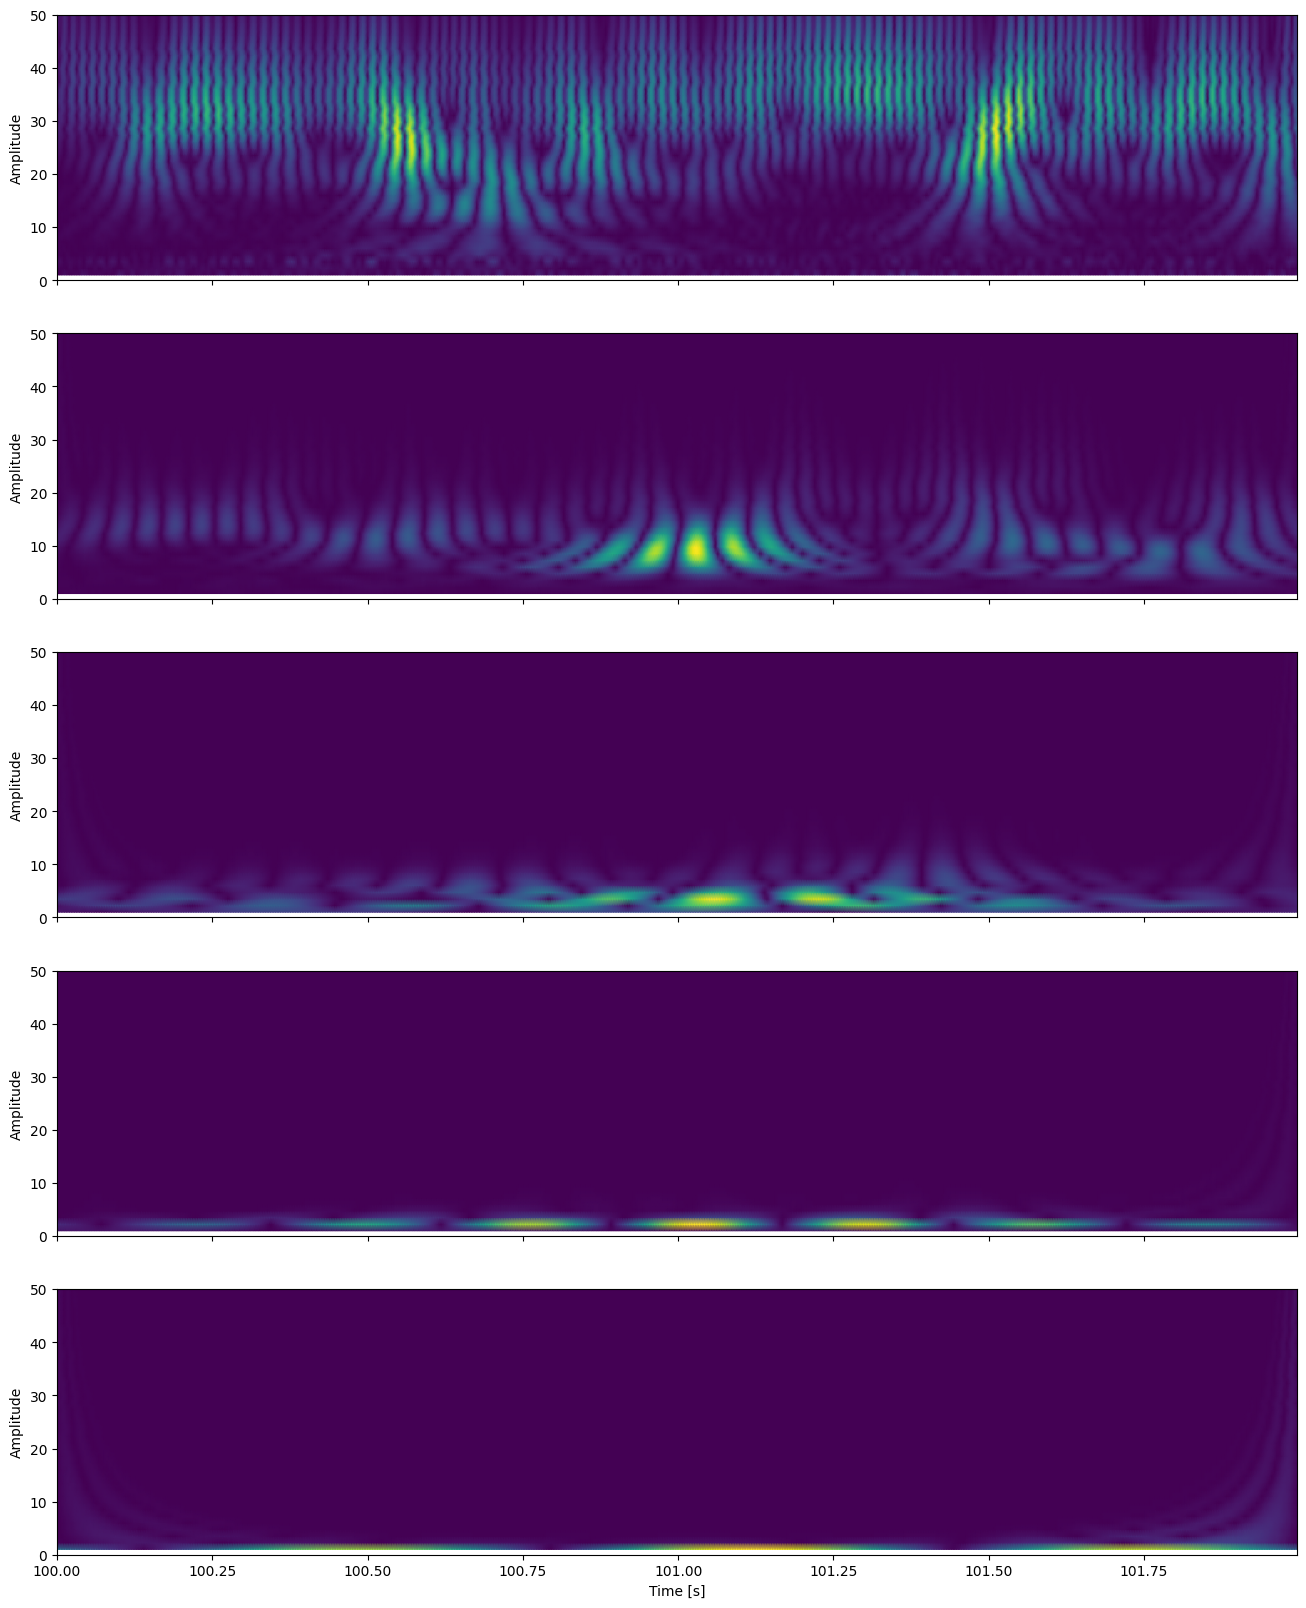

In [30]:
plot_wavelet_transform_imf(cimfs0, t, sample_rate)
plot_wavelet_transform_imf(cimfs1, t, sample_rate)

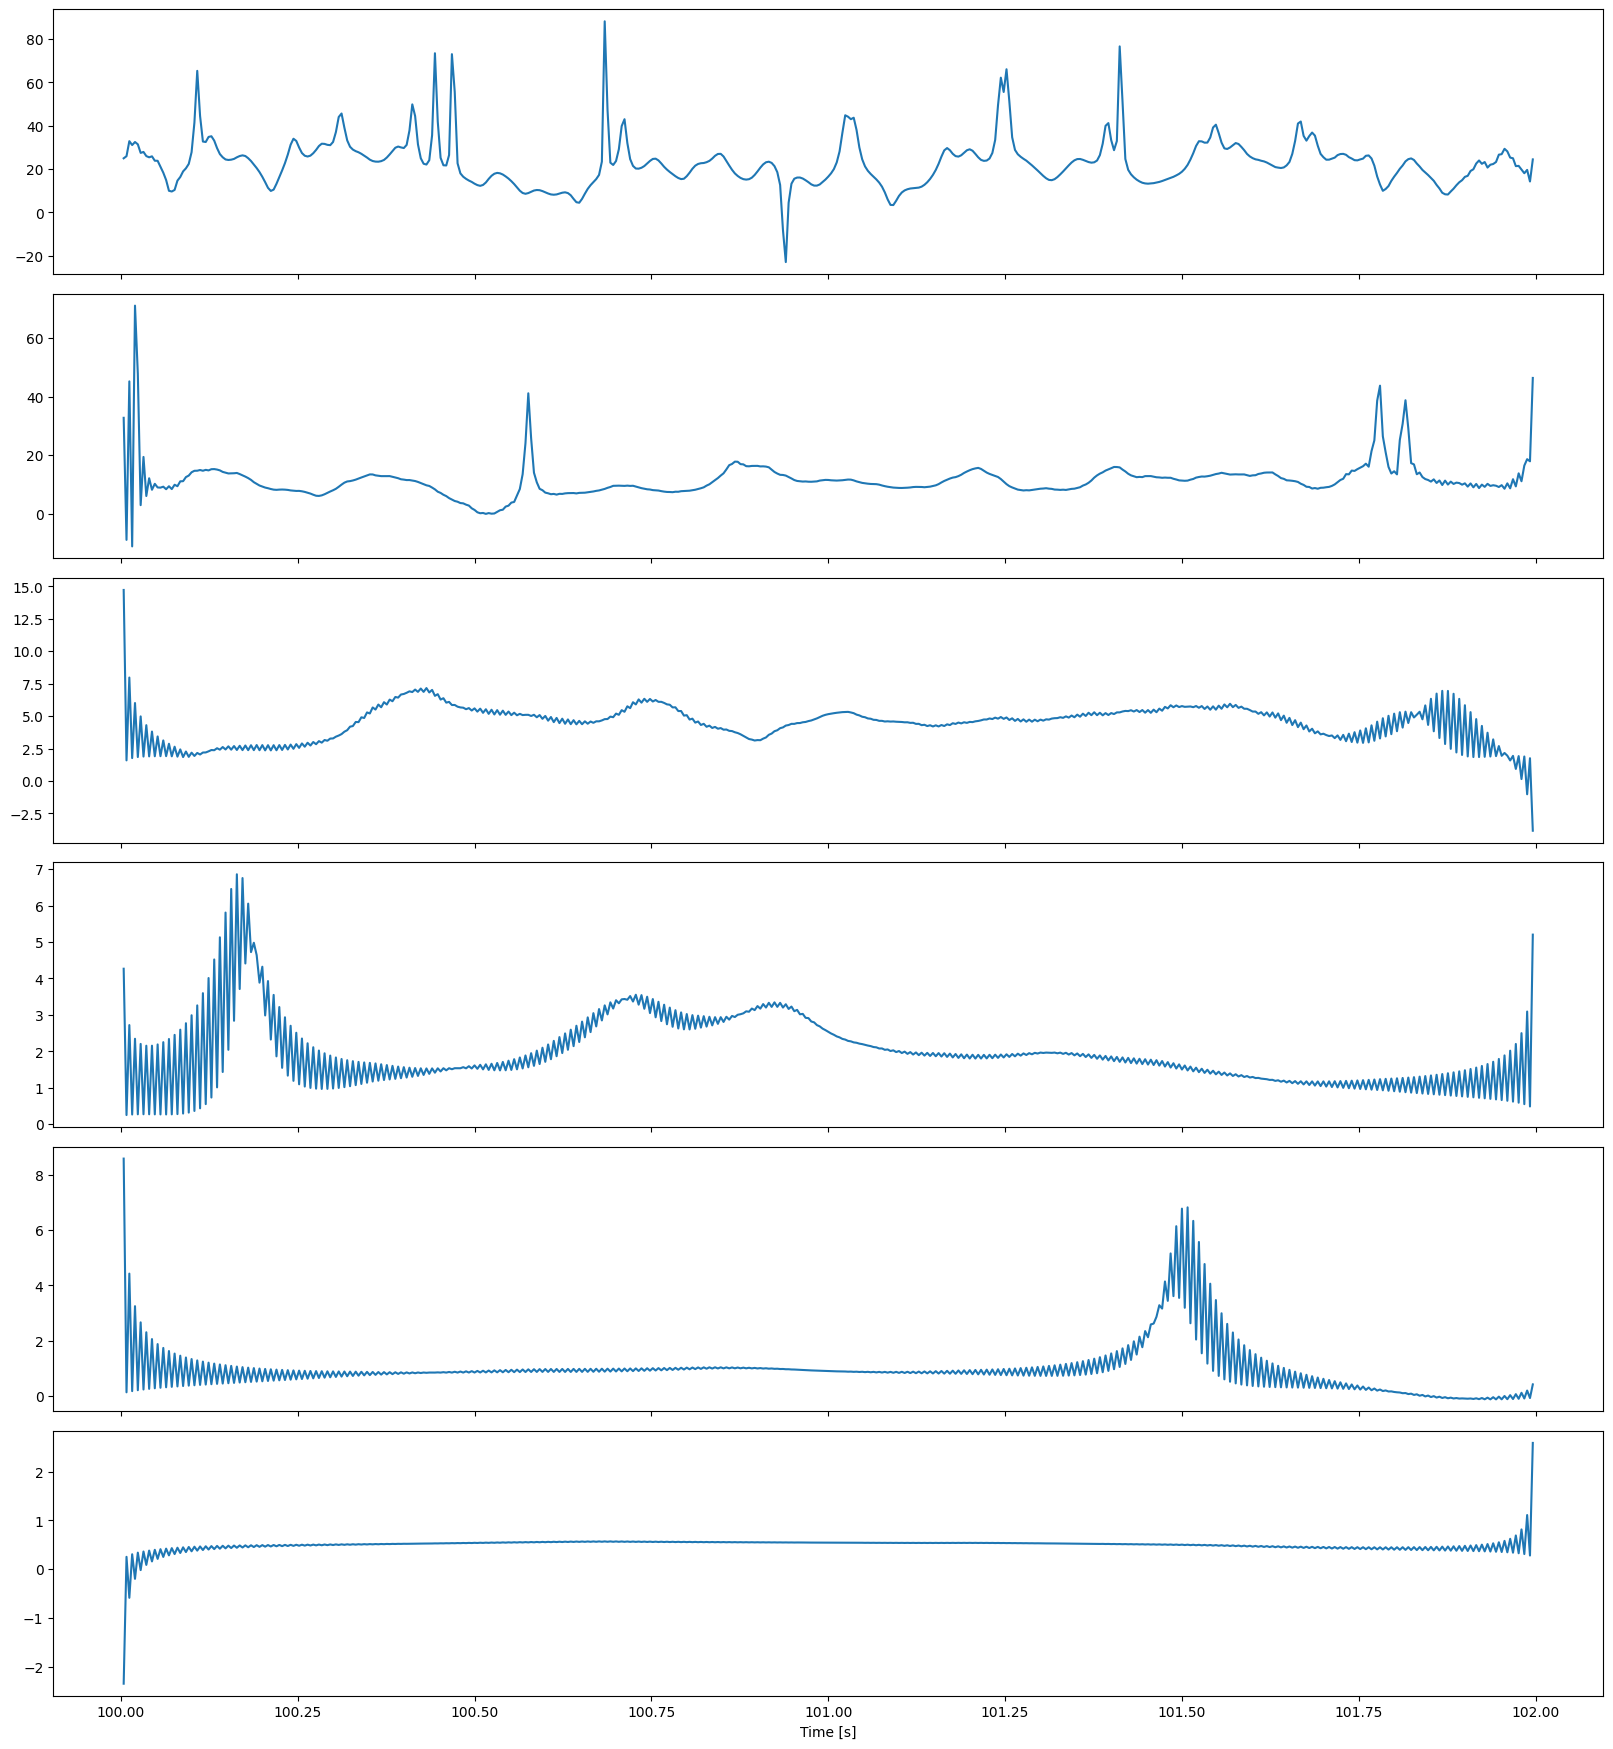

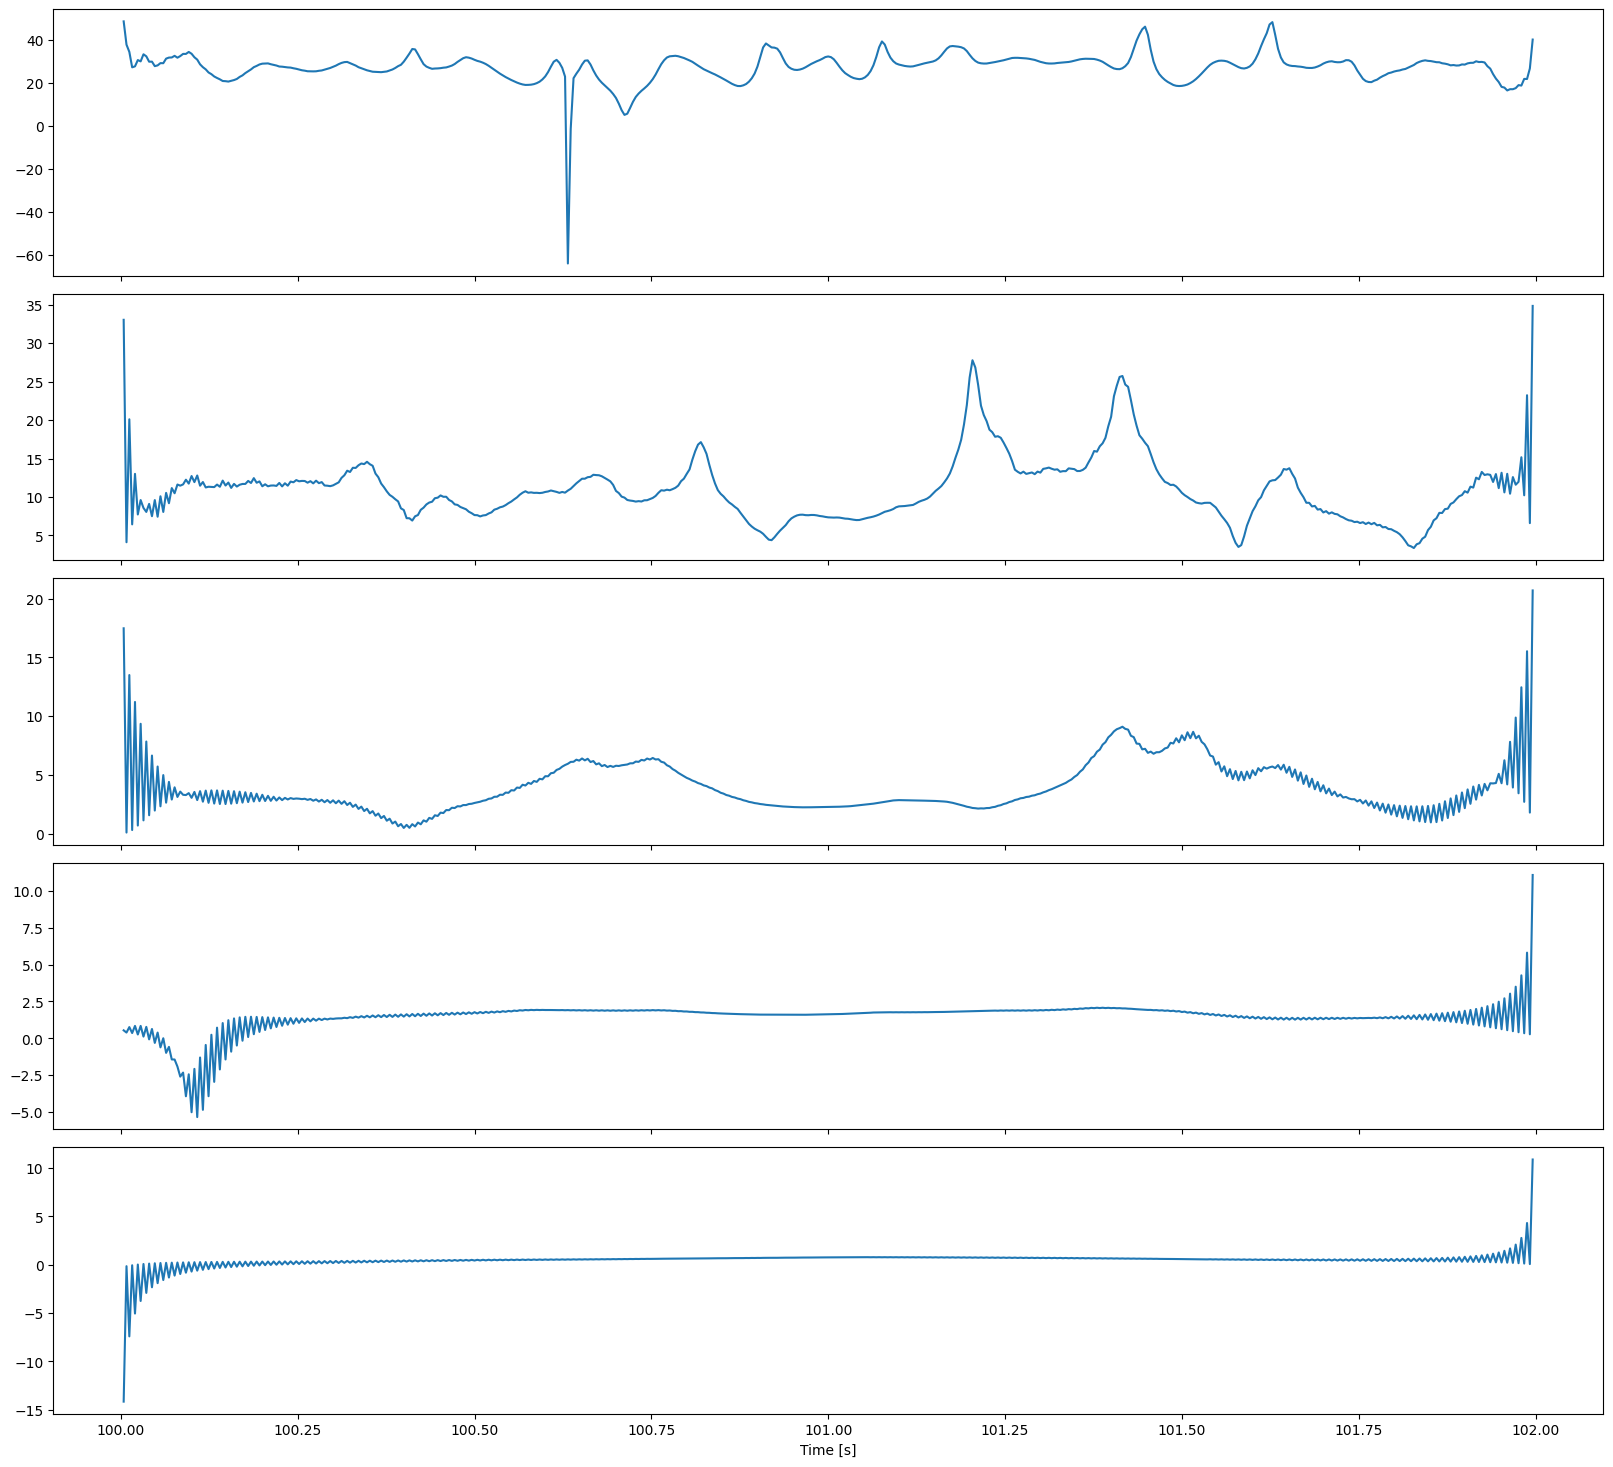

In [31]:
plot_hilbert_transform_imf(cimfs0, t, sample_rate, plot_envelope=False)
plot_hilbert_transform_imf(cimfs1, t, sample_rate, plot_envelope=False)